# Bachelier 

We consider the Bachelier model for a call option with European payoff $(S_T - K)^+$:

$$
d{F_t} = \sigma d{W_t},
$$

where:
- $d{W_t}$ denotes a Wiener process
- $\sigma$ is the constant volatility

This is a simplified view using a forward measure and forward price: $F_t=S_t e^{r(T-t)}$, where $r$ is the risk-free interest rate.

Furthermore, consider Gaussian basket: $$F_t = \sum_{i=0}^{m} \omega_i F^{[i]}_t.$$
It is a weighted sum of the underlying jointly Gaussian distributed assets.
Unlike lognormally distributed prices, the basket price $F_t$ is again Gaussian.
That is why the Bachelier model is again applicable.

In the following code the spot and forward price are used interchangibly.


We can discretize this SDE using, e.g., the Euler-Maryuama scheme. Then the samples for training are computed using Monte Carlo and the pathwise derivative method. 

# General Imports and Settings

In [1]:
# Make sure the following packages are installed:
# matplotlib, numpy, jaxlib, jax, jaxtyping, optax, chex, tensorflow, tensorflow-datasets

%pip install matplotlib
%pip install numpy

# install required jax packages
%pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install equinox jaxtyping optax chex

# install tensorflow datasets for data loading
%pip install tensorflow
%pip install tensorflow-datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# option to disable preallocation. Otherwise Jax will commit 90% of VRAM (GPU) 
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Callable
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

# we use tf with tfds for loading the data
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# Note: The warnings from tf can safely be ignored.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

# check for nans etc.
jax.enable_checks = True

2023-11-08 12:19:49.489648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 12:19:49.489671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 12:19:49.489693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# check if jax recognizes the GPU
jax.devices()

[cuda(id=0)]

In [3]:
# list requirements of latest run
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.20
equinox==0.11.1
optax==0.1.7
chex==0.1.83
tensorflow==2.14.0
tensorflow_datasets==4.9.3
numpy==1.24.4


In [20]:
# optional style change for print-ready figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "EB Garamond",
    "font.size": 20
})

In [4]:
# global settings

NUM_EPOCHS = 100
BATCH_SIZE = 512
BUFFER_SIZE = 1024
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [5]:
# helper functions

@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [6]:
def mse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [7]:
def rmse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.sqrt(mse(y, pred_y))

# Smoothing

In [8]:
def sigmoidal_smoothing(f1: Callable, f2: Callable, p=0.0, w=0.005):
    """
    Smoothly transition between two functions using sigmoidal smoothing.

    Args:
        f1 (callable): The first function, f1(x), where x is a real number.
        f2 (callable): The second function, f2(x), where x is a real number.
        p (float, optional): The position to transition between the two functions. Default is 0.0.
        w (float, optional): The width of the smoothing. Default is 0.005.

    Returns:
        callable: A function that smoothly transitions between f1 and f2 at point p.

    Example:
        zero_fn = lambda x: jnp.zeros_like(x)
        id_fn   = lambda x: x
        smooth_fn = sigmoidal_smoothing(zero_fn, id_fn, p=1.0, w=0.01)
        result = smooth_fn(0.5)
    """

    def sigma(x):
        """
        Sigmoid function for smoothing.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the sigmoid function.
        """
        return 1.0 / (1.0 + jnp.exp(-(x-p)/w))

    def smooth_f(x):
        """
        Smoothed function.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the smoothed function.
        """
        return (1 - sigma(x)) * f1(x) + sigma(x) * f2(x)

    return smooth_f


In [9]:
smooth_relu = sigmoidal_smoothing(lambda x: jnp.zeros_like(x), lambda x: x)
smooth_relu_fn = lambda w: sigmoidal_smoothing(lambda x: jnp.zeros_like(x), lambda x: x, w=w)

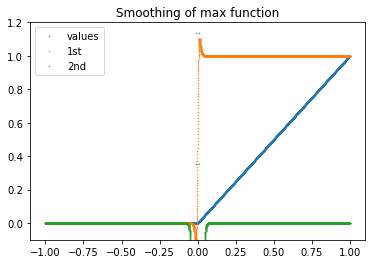

In [10]:
xs = jnp.linspace(-1e-0, 1e-0, 10000)
ys = smooth_relu(xs)
dys = jax.vmap(jax.grad(smooth_relu))(xs)
ddys = jax.vmap(jax.hessian(smooth_relu))(xs)


plt.title("Smoothing of max function")
plt.plot(xs, ys, '.', markersize=1.0, label="values")
plt.plot(xs, dys, '.', markersize=1.0, label="1st")
plt.plot(xs, ddys, '.', markersize=1.0, label="2nd")
plt.ylim([-0.1, 1.2])
plt.legend()
plt.show()

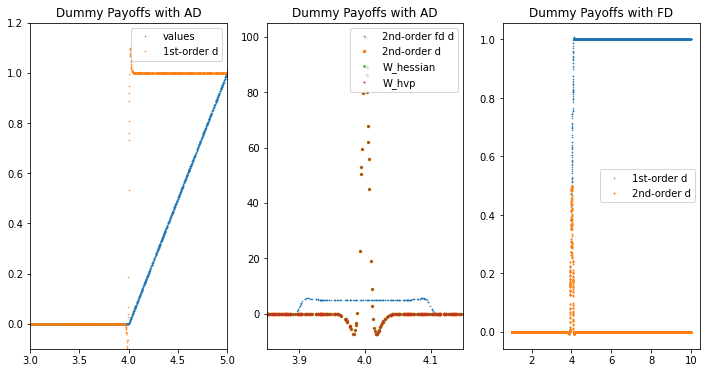

In [11]:
# Example visualizaiton of smoothed payoff and its (second-order) derivative
K = 4

def dummy_payoff(xs, K=4):
    return jnp.maximum(0, xs - K)

smoothed_dummy_payoff = lambda x, K=4: smooth_relu(x - K)
dummy_payoff = smoothed_dummy_payoff

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

# AD
dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

Z_jacobian = jax.vmap(jax.jacobian(dummy_payoff))(xs)
assert(jnp.allclose(dys, Z_jacobian))
W_hessian = jax.vmap(jax.hessian(dummy_payoff))(xs)
assert(jnp.allclose(ddys, W_hessian))

Y_vjp, vjpfun = jax.vjp(dummy_payoff, xs)
basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
W_hvp = jax.jvp(jax.vmap(jax.grad(dummy_payoff)), (xs, ), (jnp.ones_like(xs), ))[1]

# FD over AD
h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, '.', markersize=1, label='values')
axs[0].plot(xs, dys, '.', markersize=1, label='1st-order d')
axs[0].set_xlim([K-1, K+1])
axs[0].set_ylim([-.1, 1.2])
axs[0].legend()

# Second plot
axs[1].set_title("Dummy Payoffs with AD")
axs[1].plot(xs, ddys_fd, '.', markersize=1, label='2nd-order fd d')
axs[1].plot(xs, ddys, '.', markersize=5, label='2nd-order d')
axs[1].plot(xs, W_hessian, '.', markersize=3, label='W_hessian')
axs[1].plot(xs, W_hvp, '.', markersize=2, label='W_hvp')
axs[1].set_xlim([K-1.5e-1, K+1.5e-1])
axs[1].legend()

# FD
h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# Third plot
axs[2].set_title("Dummy Payoffs with FD")
axs[2].plot(xs, fd, '.', markersize=1, label='1st-order d')
axs[2].plot(xs, fdd, '.', markersize=2, label='2nd-order d')
axs[2].legend()

plt.show()

# Bachelier Dataset

## Analytic solution

In [12]:
# Initial Bachelier code was adapted from Huge & Savine, 2020, Differential Machine Learing

# analytic solutions
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)

def bachGamma(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.pdf(d) / (vol * jnp.sqrt(T))

def analytic_grad(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        # differentials
        Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z_analytic = 0.5 * (Z1 + Z2)
                
    else: # standard 
        Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        jax.debug.print("analytic {}", jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)).shape)
        jax.debug.print("weights {}",  a.reshape((1,-1)).shape)
        jax.debug.print("z_analytic {}", Z_analytic.shape)

    return Z_analytic

## Training data generator

In [13]:
@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = False

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)

class TestSet(eqx.Module):
    spots: Array
    baskets: Array
    prices: Array
    deltas: Array
    vegas: Array
    gammas: Array


def payoff_fn(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = smooth_relu(bkt2 - K)
    
    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = smooth_relu(bkt2a - K)
        Y = 0.5 * (pay + paya)
    else: # standard
        Y = pay

    return Y
    
# generate a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2) -> TrainingSet:
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)
    jax.debug.print("corr is {}", corr)
    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    jax.debug.print("basket asset weights are {}", a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    jax.debug.print("vols is {}", vols.shape)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    jax.debug.print("avols is {}", avols.shape)
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    jax.debug.print("v.shape is {}", v.shape)
    vols = vols * bktVol / v
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    jax.debug.print("diagv {}", diagv.shape)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    jax.debug.print("cov {}", cov.shape)
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))

    jax.debug.print("normals 0 is {}", normals[0, :, :].shape)
    jax.debug.print("chol0 is {}", chol0.T.shape)
    inc0 = normals[0, :, :] @ chol0.T

    jax.debug.print("inc0.shape is {}", inc0.shape)
    
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

      
    payoff = partial(payoff_fn, a=a, K=K, anti=params.anti)

    Z_analytic = analytic_grad(S1, inc1, a, K, anti=params.anti)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    
    # if not independent, we need to use the commented out section instead
    basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
    Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    # using first order finite differences
    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(W_fd_of_fd, W_fd_of_vjp): {mse}", mse=mse(W_fd_of_fd, W_fd_of_vjp))
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=mse(Z_grad, Z_analytic))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=mse(Z_vjp, Z_analytic))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=mse(Y_vjp, Y))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic, rtol=1e-4, atol=1e-0))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic, rtol=1e-4, atol=1e-0))

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)


## Test data generator

In [14]:
def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42) -> TestSet:
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1)
    gammas = bachGamma(baskets, K, bktVol, T2 - T1)
    return TestSet(spots, baskets, prices, deltas, vegas, gammas) 

## Data generation

### 1D for visualization

In [15]:
bachelier_params = BachelierParams(n_dim=1, anti=True)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)

inc0.shape is (array(8192), array(1))
chol0 is (array(1), array(1))
normals 0 is (array(8192), array(1))
cov (array(1), array(1))
diagv (array(1), array(1))
bkt vol is= 0.2
v.shape is (array(1),)
avols is (array(1), array(1))
vols is (array(1),)
basket asset weights are [1.]
corr is [[1.]]
Example values: 1.0, 1.0
MSE(W_fd_of_fd, W_fd_of_vjp): 0.30469131302001895
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True
MSE(Z_grad, Z_analytic) = 0.0005660154384085881
MSE(Z_vjp, Z_analytic) = 0.0005660154384085881
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True


#### Plot generated Data

In [16]:
def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, '.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, '.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, '.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, '.', label='Delta Test', markersize=1)
    axs.legend()

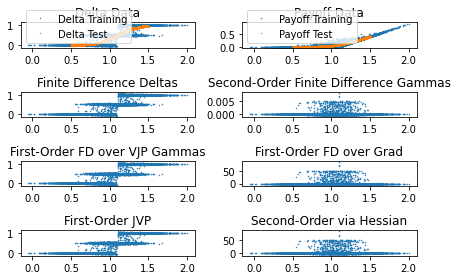

In [17]:
fig, axs = plt.subplots(4, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, '.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, '.', label='FD', markersize=1)

axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, ".", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, ".", label='FD', markersize=1)

axs[3, 0].set_title("First-Order JVP")
axs[3,0].plot(Xs, Z, ".", markersize=1)
axs[3, 1].set_title("Second-Order via Hessian")
axs[3,1].plot(Xs, W[:, 0, 0], ".", markersize=1)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


### 7D for training

In [18]:
use_anti = True
bachelier_params = BachelierParams(n_dim=7, anti=use_anti)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K, anti=use_anti)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
inc0.shape is (array(8192), array(7))
chol0 is (array(7), array(7))
normals 0 is (array(8192), array(7))
cov (array(7), array(7))
diagv (array(7), array(7))
v.shape is (array(1),)
avols is (array(7), array(1))
vols is (array(7),)
basket asset weights are [0.03523608 0.1942886  0.20768846 0.20812615 0.0497394  0.07701987
 0.22790145]
corr is [[ 1.         -0.40546809 -0.47076783  0.11005226  0.14389416  0.51420213
   0.42370432]
 [-0.40546809  1.          0.0184815  -0.10023294 -0.09547748 -0.04642767
   0.14553872]
 [-0.47076783  0.0184815   1.         -0.26878084  0.00815408 -0.34896792
  -0.41113086]
 [ 0.11005226 -0.10023294 -0.26878084  1.          0.03660357  0.48016104
  -0.35015074]
 [ 0.14389416 -0.09547748  0.00815408  0.03660357  1.         -0.06546545
   0.12895142]
 [ 0.51420213 -0.04642767 -0.34896792  0.48016104 -0.06546545  1.
  -0.07214193]
 [ 0.42370432  0.14553872 -0.41113086 -0.35015074  0.12895142 -0.07214193
   1.        ]]
MSE(Y_vjp, Y) = 0.0
Close

#### Plot generated Data

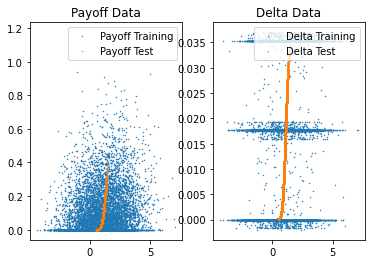

In [19]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

# Standard ML

In [20]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [21]:
x_train = X
y_train = Y
dydx_train = Z

In [22]:
# Hyperparameters
# batch_size = 128
# learning_rate = 0.01
num_epochs = NUM_EPOCHS
seed = 42

key = jax.random.PRNGKey(seed)

In [69]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key, in_size, out_size):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, 
                                  activation=smooth_relu_fn(w=3.0)), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [24]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
    out, in_ = weight.shape
    stddev = jnp.sqrt(1 / in_)
    return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    new_model = eqx.tree_at(get_weights, model, new_weights)
    return new_model


In [25]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [26]:
@eqx.filter_jit
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(MakeScalar(model))(x)
    pred_y = pred_y[:, jnp.newaxis]
    result = mse(y, pred_y)
    return result

In [27]:
def evaluate(model, testloader):
    """
    This function evaluates the model on the test dataset,
    computing both the average loss.
    """
    avg_loss = 0
    for (x, y, _) in testloader:
        avg_loss += loss_fn(model, x, y)
    return avg_loss / len(testloader)

## Train

In [28]:
def train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, _) in generator_train_ds:

            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

        test_loss = jnp.sqrt(evaluate(model, generator_test_ds))
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [29]:
def gen_data_standard_ml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [30]:
def bachelier_train_standard_ml(key: Array):
    key, subkey = jax.random.split(key)
    # model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    # use linear on-cycle decay scheduler
    num_epochs = 100
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    # print(total_steps)
    # lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
    #                                                                  pct_start=0.2, pct_final=0.6,
    #                                                                  div_factor=1000., final_div_factor=1.0e4)
    
    
    lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
    
    # lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
    # lr_schedule = optax.constant_schedule(0.0001)
    # lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    # optim = optax.adam(learning_rate=0.001)
    # optim = optax.adam(learning_rate=lr_schedule)
    optim = optax.adam(learning_rate=lr_schedule)
    # model = MakeScalar(model)
    model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)
    return model

In [31]:
generator_train_ds, generator_test_ds, x_test = gen_data_standard_ml()
key = jax.random.PRNGKey(42)
model = bachelier_train_standard_ml(key)

Finished epoch   0  | Train Loss: 0.00982  | Test Loss: 0.05259
Finished epoch   1  | Train Loss: 0.00620  | Test Loss: 0.04349
Finished epoch   2  | Train Loss: 0.00433  | Test Loss: 0.03151
Finished epoch   3  | Train Loss: 0.00296  | Test Loss: 0.02272
Finished epoch   4  | Train Loss: 0.00250  | Test Loss: 0.01706
Finished epoch   5  | Train Loss: 0.00192  | Test Loss: 0.01343
Finished epoch   6  | Train Loss: 0.00161  | Test Loss: 0.01121
Finished epoch   7  | Train Loss: 0.00163  | Test Loss: 0.00998
Finished epoch   8  | Train Loss: 0.00154  | Test Loss: 0.00904
Finished epoch   9  | Train Loss: 0.00174  | Test Loss: 0.00839
Finished epoch  10  | Train Loss: 0.00146  | Test Loss: 0.00782
Finished epoch  11  | Train Loss: 0.00150  | Test Loss: 0.00732
Finished epoch  12  | Train Loss: 0.00143  | Test Loss: 0.00700
Finished epoch  13  | Train Loss: 0.00145  | Test Loss: 0.00677
Finished epoch  14  | Train Loss: 0.00168  | Test Loss: 0.00652
Finished epoch  15  | Train Loss: 0.0014

In [32]:
class Predictions(eqx.Module):
    y: Array
    dydx: Array
    ddyddx: Array

@eqx.filter_jit
def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(xs)
    pred_ddyddx = vmap(jax.hessian(MakeScalar(model)))(xs)

    return Predictions(pred_y, pred_dydx, pred_ddyddx)
    

In [33]:
pred = predict(model, x_test)

In [34]:
@eqx.filter_jit
def eval(pred: Predictions, test_set: TestSet):
    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]
    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    rmse_y = rmse(pred_y, y_test)
    rmse_dydx = rmse(pred_dydx, dydx_test)
    rmse_ddyddx = rmse(pred_gammas, gammas)
    
    return rmse_y, rmse_dydx, rmse_ddyddx

## Plot results

### For notebook

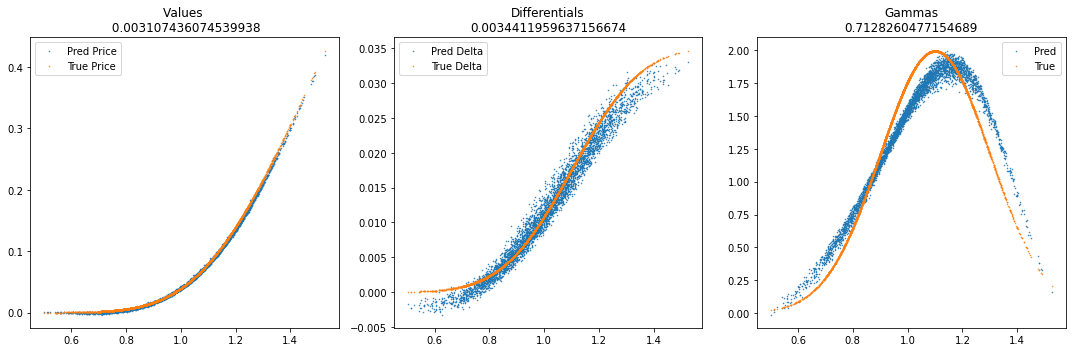

In [35]:
import datetime

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str):

    def print_rmse(pred, true):
        plt.title(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    axes[0].plot(baskets, pred_y, '.', markersize=1)
    axes[0].plot(baskets, y_test, '.', markersize=1)
    axes[0].legend(['Pred Price', 'True Price'], loc='upper left')
    axes[0].set_title(f"Values \n {rmse(pred_y, y_test)}")

    # Plot the second subplot
    dydx_idx = 0
    axes[1].plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    axes[1].plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    axes[1].legend(['Pred Delta', 'True Delta'], loc='upper left')
    axes[1].set_title(f"Differentials\n{rmse(pred_dydx, dydx_test)}")

    # Calculate and plot gammas in the third subplot
    pred_gammas = jnp.sum(pred_ddyddx, axis=(1, 2))
    axes[2].plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    axes[2].plot(baskets, gammas, '.', markersize=1, label='True')
    axes[2].legend()
    axes[2].set_title(f"Gammas\n{rmse(pred_gammas, gammas)}")

    # Adjust the layout and save the figure to a PDF file
    plt.tight_layout()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'results/all_at_once/eval_{method}_{now}.pdf', bbox_inches='tight')

plot_eval(model, pred, test_set, "ml")


### For latex

In [458]:
import datetime

BASE_PATH  = "results/single/"
VALUE_PATH = "values/"
DELTA_PATH = "deltas/"
GAMMA_PATH = "gammas/"

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str, format: str = "pdf"):

    def print_rmse(pred, true):
        # plt.title(f"RMSE: {rmse(true, pred)}")
        print(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    
    fig = plt.figure()
    print_rmse(pred_y, y_test)
    # plt.suptitle("Evaluation")
    plt.plot(baskets, pred_y, '.', markersize=1)
    plt.plot(baskets, y_test, '.', markersize=1)
    # plt.ylabel(r'$V$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Price', 'True Price'], loc='upper left')
    plt.show()
    
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{VALUE_PATH}eval_{method}_{now}.{format}', bbox_inches='tight')

    
    fig = plt.figure()
    print_rmse(pred_dydx, dydx_test)
    # plt.suptitle("Differentials")
    dydx_idx = 0
    plt.plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    plt.plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    # plt.ylabel(r'$\frac{\partial V}{\partial S_0}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{DELTA_PATH}eval_delta_{method}_{now}.{format}', bbox_inches='tight')


    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    fig = plt.figure()
    print_rmse(pred_gammas, gammas)
    # plt.suptitle("Gammas")
    plt.plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    plt.plot(baskets, gammas, '.', markersize=1, label='True')
    # plt.ylabel(r'$\frac{\partial^2 V}{\partial S_0^2}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{GAMMA_PATH}eval_gamma_{method}_{now}.{format}', bbox_inches='tight')


RMSE: 0.0034459942302796616


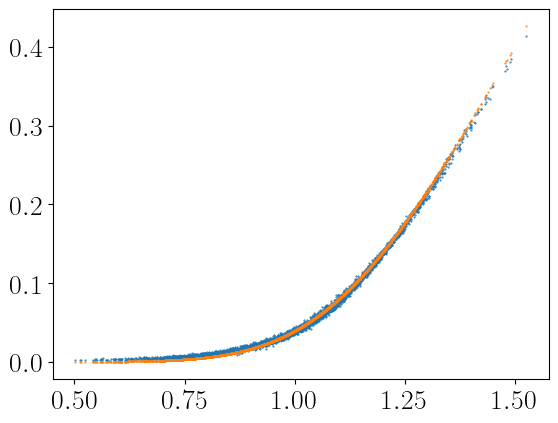

RMSE: 0.005496625771726484


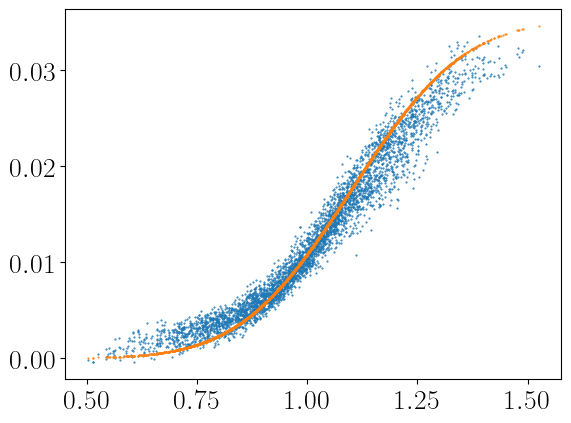

RMSE: 0.9754670337612588


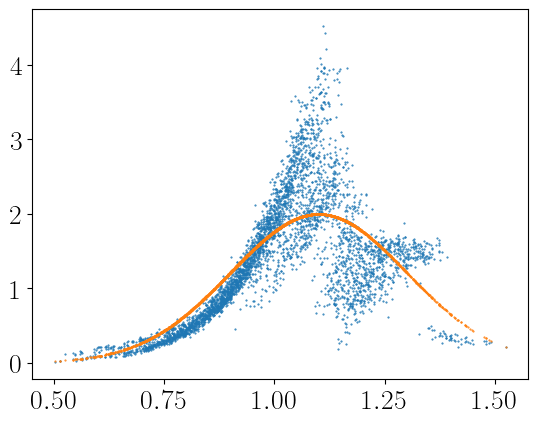

In [459]:
plot_eval(model, pred, test_set, "standard_ml")

## Learning Rate Schedule

### Visualization

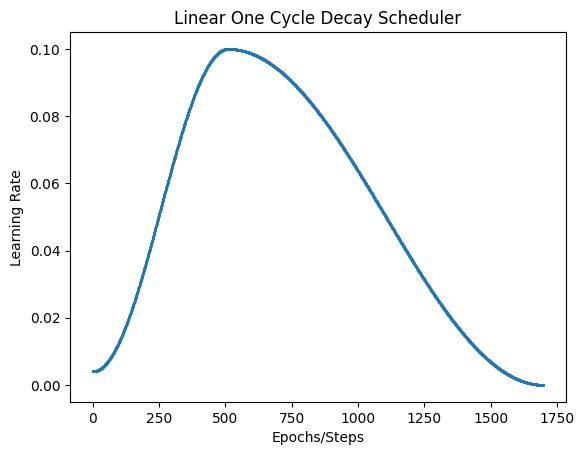

In [99]:
lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
                                                                 pct_start=0.2, pct_final=0.6,
                                                                 div_factor=10., final_div_factor=1.0e6)


lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.1)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

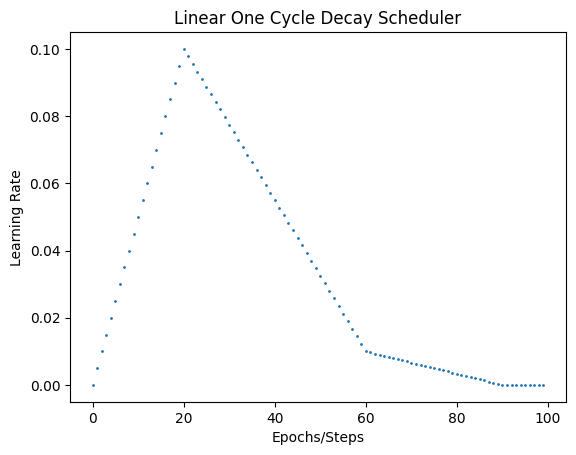

In [100]:
# this is the learning rate used by Savine et al.
lr_data = jnp.array([1e-08, 0.0050000095, 0.010000009, 0.0150000085, 0.020000008000000003, 0.025000007500000004, 0.030000007000000002, 0.03500000650000001, 0.040000006000000005, 0.0450000055, 0.05000000500000001, 0.055000004500000005, 0.060000004, 0.0650000035, 0.070000003, 0.0750000025, 0.080000002, 0.0850000015, 0.090000001, 0.0950000005, 0.1, 0.09775, 0.0955, 0.09325, 0.09100000000000001, 0.08875000000000001, 0.08650000000000001, 0.08425, 0.082, 0.07975000000000002, 0.07750000000000001, 0.07525000000000001, 0.07300000000000001, 0.07075000000000001, 0.0685, 0.06625, 0.064, 0.061750000000000006, 0.059500000000000004, 0.057249999999999995, 0.05499999999999999, 0.052750000000000005, 0.0505, 0.04825, 0.046, 0.04375, 0.041499999999999995, 0.03925000000000001, 0.037000000000000005, 0.03475, 0.0325, 0.03025, 0.027999999999999997, 0.025749999999999995, 0.023499999999999993, 0.02124999999999999, 0.01899999999999999, 0.01675, 0.014499999999999999, 0.012249999999999997, 0.01, 0.0096667, 0.0093334, 0.009000099999999999, 0.008666799999999999, 0.008333499999999999, 0.008000199999999999, 0.007666899999999998, 0.007333599999999997, 0.007000300000000001, 0.006667000000000001, 0.006333700000000001, 0.0060004, 0.0056671000000000004, 0.0053338, 0.0050005, 0.0046672, 0.004333899999999999, 0.004000599999999999, 0.0036672999999999983, 0.0033339999999999984, 0.0030006999999999976, 0.002667400000000001, 0.0023341000000000013, 0.0020008000000000005, 0.0016675000000000006, 0.0013342000000000007, 0.0010009000000000007, 0.0006675999999999991, 0.0003342999999999992, 1e-06, 9.009999999999998e-07, 8.019999999999997e-07, 7.029999999999997e-07, 6.040000000000005e-07, 5.050000000000005e-07, 4.0600000000000033e-07, 3.070000000000002e-07, 2.0800000000000006e-07, 1.0899999999999993e-07])
plt.scatter(range(len(lr_data)), lr_data, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

# Differential ML

## Data generation

In [36]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    loss = value_loss + grad_loss

    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [37]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

## Train

In [38]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, batch_dydx) in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

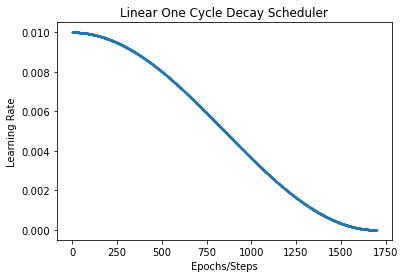

In [39]:
# linear_onecycle_decay_scheduler = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=100., final_div_factor=1.0e6)

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                 pct_start=0.2, pct_final=0.6,
#                                                 div_factor=100., final_div_factor=1.0e6)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [40]:
def gen_data_dml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [41]:
def bachelier_train_dml(key: Array):
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    seed = SEED
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    optim = optax.adam(learning_rate=lr_schedule)
    model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)
    return model

In [42]:
generator_train_ds, generator_test_ds, x_test = gen_data_dml()
y_test = prices
key = jax.random.PRNGKey(42)
model = bachelier_train_dml(key)

Finished epoch   0  | Train Loss: 0.00144  | Test Loss: 0.03630
Finished epoch   1  | Train Loss: 0.00109  | Test Loss: 0.01474
Finished epoch   2  | Train Loss: 0.00116  | Test Loss: 0.00836
Finished epoch   3  | Train Loss: 0.00112  | Test Loss: 0.00243
Finished epoch   4  | Train Loss: 0.00102  | Test Loss: 0.00202
Finished epoch   5  | Train Loss: 0.00105  | Test Loss: 0.00201
Finished epoch   6  | Train Loss: 0.00094  | Test Loss: 0.00179
Finished epoch   7  | Train Loss: 0.00100  | Test Loss: 0.00286
Finished epoch   8  | Train Loss: 0.00105  | Test Loss: 0.00318
Finished epoch   9  | Train Loss: 0.00095  | Test Loss: 0.00340
Finished epoch  10  | Train Loss: 0.00099  | Test Loss: 0.00574
Finished epoch  11  | Train Loss: 0.00097  | Test Loss: 0.00383
Finished epoch  12  | Train Loss: 0.00101  | Test Loss: 0.00437
Finished epoch  13  | Train Loss: 0.00106  | Test Loss: 0.00313
Finished epoch  14  | Train Loss: 0.00107  | Test Loss: 0.00258
Finished epoch  15  | Train Loss: 0.0010

## Plot results

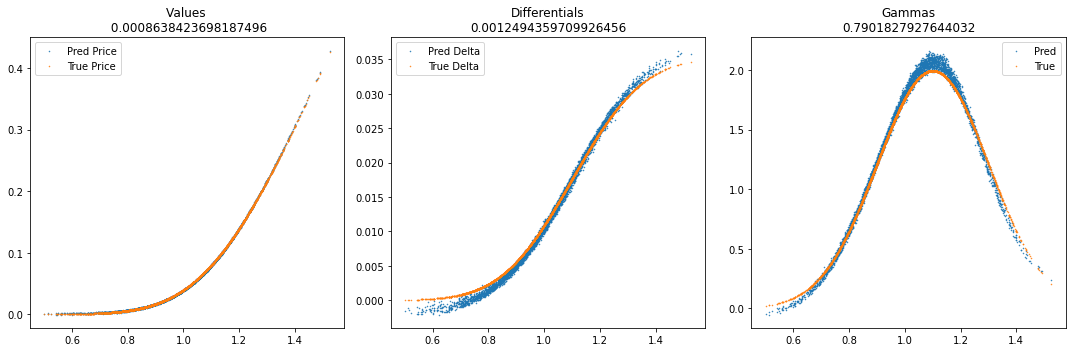

In [43]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "dml")

# Second-Order Differential ML with PCA

## Data generation

In [44]:
def hvp(f, primals, tangents):
    return jax.jvp(lambda x: eqx.filter_grad(f)(x), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals, ), (tangents, ))

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

def hvp_args(f, primals, tangents, *f_args):
    return jax.jvp(lambda x: eqx.filter_grad(f)(x, *f_args), primals, tangents)[1]

def hmp_args(f, primals, *f_args):
    
    def hvp_(tangents):
        return hvp_args(f, (primals,), (tangents, ), *f_args)

    return eqx.filter_vmap(hvp_)

def batch_hmp_args(f, vmapped_args: Tuple = ()):

    def hvp_(primals, tangents, *f_args):
        return hvp_args(f, (primals, ), (tangents, ), *f_args)

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None, *vmapped_args)), in_axes=(None, 1, *tuple([None for _ in range(len(vmapped_args))])))

# jax cannot deal with dynamic slices of arrays
# therefore, we cannot simply slice the principal_components array while using batch_hmp

# this is a version where a 0 vector principal component will lead to a different path (namely returning 0) compared to computing a hvp.
def cond_fn_pca(tangents, *args):
    # xs, cum_sum = x
    # return cum_sum > 0.95

    # jax.debug.print("tangents {tangents}", tangents=tangents)

    return jnp.any(tangents[0] > 0.0)  # NOTE: we set the tangents to zero if we do not want to compute its derivative (because principle component is too small)

def hvp_pca(f, primals, tangents):
    return jax.lax.cond(cond_fn_pca(tangents), lambda _: hvp(f, primals, tangents), lambda _: tangents[0], None)

def batch_hmp_select(f):

    def hvp_(primals, tangents):
        return hvp_pca(f, (primals,), (tangents,))

    # x = jnp.zeros(shape=(1, 1))
    # jax.lax.while_loop(cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!
    # jnp.piecewise(x, cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

# this is a version where we explicitly add a list of boolean values, indicating whether we should compute the hvp or not
def hvp_conditional(f, primals, tangents, eval_hvp):
    # jax.debug.print("primals {x}", x=primals)
    # jax.debug.print("tangents {x}", x=tangents)
    # jax.debug.print("eval_hvp {x}", x=eval_hvp)

    # jax.lax.cond(eval_hvp, lambda _: jax.debug.print("using hvp: {eval}", eval=eval_hvp), lambda _: jax.debug.print("not using hvp: {eval}", eval=~eval_hvp), None)

    # res = hvp(f, primals, tangents)
    # jax.debug.print("evalhvp.shape {res}", res=res.shape)
    return jax.lax.cond(eval_hvp, lambda _: hvp(f, primals, tangents), lambda _: jnp.zeros(shape=(primals[0].shape[-1],)), None)

def batch_hmp_cond(f):

    def hvp_(primals, tangents, eval_hvp):
        return hvp_conditional(f, (primals,), (tangents,), eval_hvp)

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None, None)), in_axes=(None, 1, 0))


In [45]:
def test_fn(x, ys, ts):
    jax.debug.print("x {x}", x=x)
    jax.debug.print("ys {ys}", ys=ys)
    jax.debug.print("ts {ts}", ts=ts)

    return ys + ts

xs_test = jnp.array([1.0, 2.0])
ys = jnp.array([[1.0, 2.0], [3.0, 4.0]])
ts = jnp.array([[5.0, 6.0], [7.0, 8.0]])

vmap(test_fn, in_axes=(None, 0, 0))(xs_test, ys, ts)


x [1. 2.]
ys [1. 2.]
ys [3. 4.]
ts [5. 6.]
ts [7. 8.]


Array([[ 6.,  8.],
       [10., 12.]], dtype=float64)

In [46]:
key = jax.random.PRNGKey(0)
sv = jnp.array([0.35, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1])
pc = jax.random.uniform(key, shape=(7,7))
print(pc.shape)
print(x_train.shape)

compute = ~(jnp.cumsum(sv) > 0.95)
# compute  = jnp.array([1., 2., 3., 4., 5., 6., 7.])

hmp_batch_cond_fn = batch_hmp_cond(MakeScalar(model))
res = hmp_batch_cond_fn(x_train, pc, compute)
print(res.shape)
print(res[-1])

(7, 7)
(8192, 7)
(7, 8192, 7)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:

def check_rand_vectors(rand_vectors, tol=1e-3):
    mean_outer = jnp.mean(jax.vmap(lambda x: jnp.outer(x, x))(rand_vectors), axis=0)
    print("Mean outer product of random_vectors: ", mean_outer)
    
    # should be close to the identity matrix
    identity_mtx = jnp.eye(n_dim)
    err = jnp.mean((mean_outer - identity_mtx)**2)
    print("Error compared to Identity Matrix: ", err)

    is_below_tol = err < tol
    # assert(is_below_tol)
    return is_below_tol

key = jax.random.PRNGKey(42)
n_dim = 100
n_vectors = 20000
key, subkey = jax.random.split(key)

rand_vectors = jax.random.uniform(subkey, shape=(n_dim, n_dim), minval=-1.0, maxval=1.0)
check_rand_vectors(rand_vectors)

rand_vectors = jax.random.bernoulli(subkey, shape=(n_dim, n_dim)).astype(jnp.float64)
check_rand_vectors(rand_vectors)

rand_vectors = jax.random.multivariate_normal(subkey, jnp.zeros(shape=(n_dim, )), jnp.eye(n_dim), shape=(n_vectors,))
check_rand_vectors(rand_vectors)


Mean outer product of random_vectors:  [[ 0.32502192  0.00100081  0.01688444 ...  0.00293664 -0.00743063
  -0.00821976]
 [ 0.00100081  0.3377403  -0.04925426 ... -0.01564416 -0.06370514
  -0.06554734]
 [ 0.01688444 -0.04925426  0.29293475 ... -0.01075127 -0.04631765
   0.02821271]
 ...
 [ 0.00293664 -0.01564416 -0.01075127 ...  0.33571776  0.04407756
  -0.03893282]
 [-0.00743063 -0.06370514 -0.04631765 ...  0.04407756  0.39473386
   0.08357192]
 [-0.00821976 -0.06554734  0.02821271 ... -0.03893282  0.08357192
   0.33213165]]
Error compared to Identity Matrix:  0.0055844598236545525
Mean outer product of random_vectors:  [[0.52 0.28 0.28 ... 0.32 0.23 0.31]
 [0.28 0.55 0.28 ... 0.31 0.27 0.27]
 [0.28 0.28 0.48 ... 0.3  0.23 0.25]
 ...
 [0.32 0.31 0.3  ... 0.59 0.29 0.3 ]
 [0.23 0.27 0.23 ... 0.29 0.48 0.24]
 [0.31 0.27 0.25 ... 0.3  0.24 0.48]]
Error compared to Identity Matrix:  0.06992675000000001
Mean outer product of random_vectors:  [[ 1.00483550e+00  2.87271850e-03 -1.13477710e-02

Array(True, dtype=bool)

In [48]:
class LossState(eqx.Module):
    losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    lambdas: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    initial_losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    accum_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    prev_mean_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    current_iter: Float[Array, "n_losses"] = jnp.zeros(3)

    def update_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(new_value, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses, state.current_iter)

    def update_lambdas(state, new_value: Float[Array, "n_losses"]):# -> LossState:
        return LossState(state.losses, new_value, state.initial_losses, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_initial_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, new_value, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_accum_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, new_value, state.prev_mean_losses,  state.current_iter)
        
    def update_current_iter(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses,  new_value)

    def update_prev_mean_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, new_value,  state.current_iter)

    def __repr__(self):
        return "LossState"

In [49]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']

def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'r.', markersize=1, label="True")
        plt.plot(x[:, i], dydx_pred[:, i], 'b.', markersize=1, label="Pred")
        plt.legend()
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)

        for j, _ in enumerate(principal_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-',  color=colors[j % len(colors)], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


# def plot_ddyddx(x, ddyddx):
#   plt.title("Gammas ")
#   dydx_idx = 0
#   for i in range(x_test.shape[1]):
#     for j in range(x_test.shape[1]):
#       plt.plot(baskets, pred_ddyddx[:, i, j], '.', markersize=1, label=f"Gamma {i},{j}")
#   plt.legend(loc='upper left')
#   plt.show()


def plot_ddyddx_pred(x, ddyddx):
  for i in range(x.shape[1]):
    plt.title(f"2nd-Order Differential Predictions {i}")

    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j % len(colors)], label=f"ddyddx {i},{j}")
    plt.show()


def plot_ddyddx_pred_hvp(x, ddyddx):
  plt.title(f"2nd-Order Differential HVP Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd(x, ddyddx):
  plt.title(f"2nd-Order Finite-Difference Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd_of_grad(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_grad_full(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Full Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_fd(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over FD Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()


def plot_hesse_model_vs_data(x, hesse_model, hesse_data):
  plt.title(f"Hesse Model vs Data")

  # for now we only consider one dimension
  for i in range(x.shape[-1]):
    lines_x = jnp.array([x[:, i], x[:, i]])
    lines_y = jnp.array([hesse_model[:, i, 0], hesse_data[:, i, 0]])
    plt.plot(lines_x, lines_y, c='lightgray')
    plt.plot(x[:, i], hesse_model[:, i, 0], '.', c='blue', markersize=3, label=f"hesse model")
    plt.plot(x[:, i], hesse_data[:, i, 0], '.', c='red', markersize=3, label=f"hesse data")
  plt.show()


def plot_ddyddx_pred_all(x, data_dict, n_dims):
  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, (title, ddyddx) in enumerate(data_dict.items()):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(title)
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_ddyddx_pred_cond(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['hmp_pc_cond (model)', 'ddpayoff_cond (model)', 'hmp_pc (model)', 'ddpayoff (model)']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()

def plot_ddyddx_pc_reduced(x, hmp_pc, hmp_pc2):

  fig, axs = plt.subplots(1, 3)
    
  plt.title(f"2nd-Order Differentials w/ Reduced PC")
  axs[0].set_title("hmp_pc (truncated)")
  axs[1].set_title("hmp_pc2")
  
  for i in range(hmp_pc2.shape[1]):
    for j in range(hmp_pc2.shape[-1]):
      axs[0].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
      axs[1].plot(x[:, i], hmp_pc2[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  axs[2].set_title("hmp_pc (full)")

  for i in range(hmp_pc.shape[1]):
    for j in range(hmp_pc.shape[-1]):
      axs[2].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()
    

def plot_ddyddx_pred_hess_compare(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['selected_hvp', 'hmp_pc', 'hmp_res', 'hessian']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[-1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'r.', markersize=1)
    plt.plot(x, y_pred, 'b.', markersize=1)
    plt.show()


def plot_batch_delta(x, y_delta):
    plt.title("Data Batch Delta")
    plt.plot(x, y_delta, 'b.', markersize=1)
    plt.show()


def print_ddpayoff(ddpayoff):
    nnz = ddpayoff != 0.
    ddpayoff_nnz = ddpayoff[nnz]
    print("ddpayoff: ", ddpayoff_nnz)
    
  
def print_k_pc(pc, k_pc):
  print("pc: ", pc[k_pc:, :])


In [50]:
def diff_pca_loss_fn(model: eqx.nn.MLP, loss_state: LossState, x: Float[Array, "batch"], inc1: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], key, debug: bool = True) -> Float:
    kappa = 0.95
    
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # because of pca the number of 2nd order differential data computed will not be the full hessian. Thus eta is smaller than 1 to account for this.
    # I guess it should ideally be k/n with k being the number of important dimensions (i.e., they cannot be reduced by pca). For bachelier, we know
    # that this is only 1 dimenions.
    n_important_dims = 1
    eta = (n_important_dims/n_dims) ** 2
    alpha = eta * alpha
    beta = eta * beta
    gamma = 1 - alpha - beta # NOTE: we could use the magnitue of the principle components to set this value
    
    if 1:
        scale = (1 + lam * n_dims + eta * n_dims * n_dims)
        alpha = 1 / scale
        beta = (lam * n_dims) / scale
        gamma = 1.0 - alpha - beta
        beta = 1.0 - alpha - gamma

    if 0:
        alpha = 0.2
        gamma = 0.2
        beta = 1.0 - alpha - gamma

    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    #
    # full hessian matrix
    #
    hess = jax.hessian(MakeScalar(model))
    hessian = eqx.filter_vmap(hess)(x)
    # jax.debug.print("Hessian: {H}", H=hessian.shape)
    
    #
    # hessian with custom batch_hmp
    #
    batch_hmp_fn = batch_hmp(MakeScalar(model))
    basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    hmp_res = batch_hmp_fn(x, basis)
    hmp_res = jnp.transpose(hmp_res, (1, 0, 2))

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    #
    # Compute PCA
    #
    if 1:
        dydx_pred_means = jnp.mean(dydx_pred, axis=0)
        # print("dydx_pred_means.shape:", dydx_pred_means.shape)
        # jax.debug.print("dydx_pred_means: {}", dydx_pred_means)

        tiled_dydx_pred_means = jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))
        dydx_pred_mean_adjusted = dydx_pred - tiled_dydx_pred_means

        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    elif 0:
        # Alternative approach: Use the difference of dydx_pred and dydx to get the principle components
        dydx_diff = dydx_pred - dydx
        dydx_pred_means = jnp.mean(dydx_diff, axis=0)
        dydx_pred_mean_adjusted = dydx_diff - jnp.tile(dydx_pred_means, (dydx_diff.shape[0], 1))
        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    else:
        # what if we take the dydx labels instead of the dydx_pred labels?
        dydx_mean = jnp.mean(dydx, axis=0)
        dydx_pred_mean_adjusted = dydx - jnp.tile(dydx_mean, (dydx.shape[0], 1))
        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principal components give use the directions for the hesse vectors
    principal_components = jnp.diag(S) @ VT
    # principal_components += dydx_pred_means
    
    # singular values scaled to represent % of variance explained.
    S_var = S**2 / jnp.sum(S**2)
    
    # find index k, s.t. the first k elements in S_var account for 95% of the variance
    k_pc = jnp.argmax(jnp.cumsum(S_var) > kappa) # returns first occurence of True
    k_pc = jnp.maximum(k_pc, jnp.ones_like(k_pc))

    def batch_hmp_single_tangent(f, primals):
    
        def hvp_(primals, tangents):
            return hvp(f, (primals,), (tangents,))
    
        return partial(eqx.filter_vmap(hvp_, in_axes=(0, None)), primals)

    # TODO: having input data x coupled is probably not a good idea. We want to reuse the same while_fn for every iteration.
    #       So make input data a parameter to while_fn as well.
    single_hvp_fn = batch_hmp_single_tangent(MakeScalar(model), x)
    
    def while_fn(tup):
        x, pc, mtx = tup
        # jax.debug.print("current x = {x}", x=x)
        # jax.debug.print("mtx.shape is {mtx}", mtx=mtx.shape)
        test = single_hvp_fn(pc[x, :].T)
        # jax.debug.print("test.shape is {ts}", ts=test.shape)
        mtx = mtx.at[:, x, :].set(test)
        # jax.debug.print("mtx is {mtx}", mtx=mtx)
        
        return x - 1, pc, mtx
        
    _, _, mtx = jax.lax.while_loop(lambda tup: tup[0] >= 0, while_fn, (x.shape[1], principal_components, jnp.zeros(shape=(x.shape[0], x.shape[1], x.shape[1]))))

    #
    # Compute hmp_pc_cond
    #
    
    compute_hvp = ~(jnp.cumsum(S_var) > kappa)
    # if the first principal component is already accounting for 95% of the variance, compute_hvp will be just all False.
    # Below we make use that at least the first principal component is always actively used.
    compute_hvp = compute_hvp.at[0].set(True)
    
    # jax.debug.print("compute_hvp: {v}", v=compute_hvp)
    # compute_hvp = jnp.array([True]*7)
    # compute_hvp = jnp.array([True, True, False, False, False, False, False])
    batch_hmp_cond_fn = batch_hmp_cond(MakeScalar(model))
    hmp_pc_cond = batch_hmp_cond_fn(x, principal_components.T, compute_hvp)
    hmp_pc_cond = jnp.transpose(hmp_pc_cond, (1, 0, 2))

    #
    # For comparison: Use a random selection of principal components
    #
    key, subkey = jax.random.split(key)
    pc_rand_selection = jax.random.bernoulli(key, shape=compute_hvp.shape)
    hmp_pc_rand_cond = batch_hmp_cond_fn(x, principal_components.T, pc_rand_selection)
    hmp_pc_rand_cond = jnp.transpose(hmp_pc_rand_cond, (1, 0, 2))


    #
    # For comparison: Use a random selection of exactly k_pc principal components
    #
    n_pc = principal_components.shape[0]
    l_pc = 2 # (jnp.sqrt(n_pc)).astype(jnp.int64)
    pc_indices = jnp.linspace(0, n_pc - 1, n_pc, dtype=jnp.int64)
    pc_k_selection = jnp.zeros_like(compute_hvp)
    k_rand_bools = jax.random.choice(key, pc_indices, shape=(l_pc,), replace=False)
    pc_k_selection = pc_k_selection.at[k_rand_bools].set(True)
    hmp_pc_k_rand_cond = batch_hmp_cond_fn(x, principal_components.T, pc_k_selection)
    hmp_pc_k_rand_cond = jnp.transpose(hmp_pc_k_rand_cond, (1, 0, 2))

    if debug:
      jax.debug.print("hmp_pc_cond.shape {pc}", pc=hmp_pc_cond.shape)
      jax.debug.print("compute_hvp {hvp}", hvp=compute_hvp)
     
      jax.debug.print("Singluar Values: {S}", S=S)

      jax.debug.print("Singluar Values Variance Explained: {S}", S=S_var)
      jax.debug.print("k_pc: {k_pc}", k_pc=k_pc)
      # jax.debug.print("k_pc.dtype: {k_pc}", k_pc=k_pc.dtype)


      # jax.debug.print("pc.shape[0]: {pc}", pc=principal_components.shape[0])

      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice(principal_components, (0, 0), (2, 2))

      jax.debug.print("pc {pc}", pc=principal_components)
      # jax.debug.print("first k pc {pc}", pc=principal_components[:k_pc, :])
      # print("first k pc: ", first_k_pc)

      # hvp_first_k_pc = principal_components[:2, :] @ hessian
      # jax.debug.print("hvp_first_k_pc {hvp}", hvp=hvp_first_k_pc)

    # NOTE: The principle component directions could have a factor -1 that deviates from the desired direction (e.g., vector points north instead of south in 2D case).
    #       We need to check for that and flip the sign of the principle component if necessary.
    #       This can be decided using the dydx target data.
    #       -> not an issue if we consider pc @ hessian

    # TODO: Think about the implications and whether to do this per dimension or per batch
    #       For now we do it per dimension



    # now instead of computing the hessian seperately from the identity matrix
    # we directly use the principle components

    # jax.debug.print("basis.shape {basis}", basis=basis.shape)
    # jax.debug.print("principal_components.shape {pc}", pc=principal_components.shape)

    #
    # Compute hmp with all principal components
    #
    hmp_pc = batch_hmp_fn(x, principal_components.T)
    hmp_pc = jnp.transpose(hmp_pc, (1, 0, 2))

    #
    # compute hmp with random set of vectors
    #
    # similar approach to https://arxiv.org/ftp/arxiv/papers/1206/1206.6464.pdf
    #    
    n_dim = x.shape[-1]
    key, subkey = jax.random.split(key)
    # rand_vectors = jax.random.uniform(subkey, shape=(n_dim, n_dim), minval=0.0, maxval=1.0)

    # rand_vectors = jax.random.bernoulli(subkey, shape=(n_dim, n_dim)).astype(jnp.float64)

    # print("rand_vectors {}", rand_vectors.shape)

    n_rand_vectors = n_dim
    rand_vectors = jax.random.multivariate_normal(subkey, jnp.zeros(shape=(n_dim, )), jnp.eye(n_dim))#, shape=(n_rand_vectors,))
    rand_vectors = jnp.outer(rand_vectors, rand_vectors)
    
    # rand_vectors = jax.random.normal(subkey, shape=(n_dim, n_dim))
    hmp_rand = batch_hmp_fn(x, rand_vectors)
    hmp_rand = jnp.transpose(hmp_rand, (1, 0, 2))

    
    # jax.debug.print("hmp_pc.shape {shape}", shape=hmp_pc.shape)
    
    hmp_pc2 = batch_hmp_fn(x, principal_components[:2, :].T)
    hmp_pc2 = jnp.transpose(hmp_pc2, (1, 0, 2))
    # jax.debug.print("hmp_pc2 vs hmp_pc_cond {diff}", diff= jnp.sum(hmp_pc2 - hmp_pc_cond))

    if debug:
        jax.debug.print("hmp_pc2.shape {shape}", shape=hmp_pc2.shape)
        # jax.debug.print("----------\nhmp_pc2 {pc}", pc=hmp_pc2)

    # jax.debug.print("pc2 {pc}", pc=principal_components[:2, :])

    # direction_signs = jnp.sign(jnp.sum(dydx * principal_components, axis=1))


    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principal_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    partial_vjp = partial(eqx.filter_vjp, MakeScalar(model))
    y_pred_vjp, vjp_fun = vmap(partial_vjp)(x)

    # jax.debug.print("function is: {fn}", fn=vjp_fun)
    # test_values = vmap(vjp_fun)(jnp.ones_like(y_pred_vjp))
    # jax.debug.print("test values = {tv}", tv=test_values)

    y_pred_vjp = y_pred_vjp[..., jnp.newaxis]

    # jax.debug.print("y_pred={y}", y=y_pred)
    # jax.debug.print("y_pred_vjp={y}", y=y_pred_vjp)
    # jax.debug.print("MSE(y_pred, y_pred_vjp) = {res}", res=mse(y_pred, y_pred_vjp))
    # chex.assert_trees_all_close(y_pred, y_pred_vjp)


    # jax.debug.print("shape must be: {shape}", shape=y_pred_vjp.shape)
    # jax.debug.print("but we have: {shape}", shape=x.shape)
    # dydx_pred_vjp, hvp_fun = vmap(partial(eqx.filter_vjp, vjp_fun))(x)


    # basis = jnp.eye(y_pred_vjp.size, dtype=y.dtype)
    # jac = vmap(vjp_fun)(basis)[0] 

    # ---

    # jax.debug.print("Hessian shape {H}", H=hessian.shape)
    # jax.debug.print("Principle components shape: {PC}", PC=principal_components.shape)

    # generate the missing second-order differential training data which 
    # depends on the principle components.

    # Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    D_payoff = jax.vmap(jax.grad(payoff))
    payoff_nonsmooth = True
    if payoff_nonsmooth:
    
        def cfd(f, h, x, *args):
    
          def cfd_(v):
            xph = x + h * v 
            xmh = x - h * v 
            fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)
            # jax.debug.print("fd_of_f = {fd}", fd=fd_of_f)
    
            # fd_of_f = vmap(jnp.multiply)(fd_of_f, jnp.sign(v))
            # fd_of_f = jnp.multiply(fd_of_f, jnp.sign(v))
            # jax.debug.print("fd_of_f_after = {fd}", fd=fd_of_f)
    
            # jax.debug.print("shape of v: {v}", v=v.shape)
            # jax.debug.print("fd_of_f.shape: {fd}", fd=fd_of_f.shape)
            return fd_of_f
    
          return cfd_
    
        def batch_cfd_of_dpayoff_conditional(f):
            def cfd_of_dpayoff_conditional(tangent, eval_hvp):
                return jax.lax.cond(eval_hvp, lambda t: f(t), lambda t: jnp.zeros_like(x), tangent)
                
            return eqx.filter_vmap(cfd_of_dpayoff_conditional, in_axes=(0, 0))
    
        def optimal_step(x: Float):
            h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
            return h * jnp.fabs(x)
    
        # for now consider fixed h
        # h = optimal_step(jnp.mean(x))
        # h = 5e-2
    
        # TODO: Maybe h should depend on the dimensionality of the problem?
        # h = 1e-1
        h = 1e-1
        
        # jax.debug.print("h = {h}", h=h)
        eye = jnp.eye(n_dims)
        basis = eye * h
        v = principal_components[0] 
        # jax.debug.print("v : {v}", v=v)
    
        # jax.debug.print("x : {x}", x=x)
    
        xph = x + h * v
        # jax.debug.print("xph : {xph}", xph=xph)
        xmh = x - h * v
        # jax.debug.print("xmh : {xmh}", xmh=xmh)
    
        fd_xph = D_payoff(xph, inc1)
        # jax.debug.print("fd_xph : {fd}", fd=fd_xph)
        fd_xmh = D_payoff(xmh, inc1)
        # jax.debug.print("fd_xmh : {fd}", fd=fd_xmh)
        fd_of_dpayoff = (D_payoff(xph, inc1) - D_payoff(xmh, inc1)) / (2 * h)
        # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
        # jax.debug.print("mean of fd of payoff: {fd}", fd=jnp.mean(fd_of_dpayoff, axis=0))
        # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
        
        cfd_of_dpayoff_fn = cfd(D_payoff, h, x, inc1)
        cfd_of_dpayoff = vmap(cfd_of_dpayoff_fn)
        # ddpayoff = cfd_of_dpayoff(principal_components[:2, :])
        ddpayoff = cfd_of_dpayoff(principal_components)
        ddpayoff = jnp.transpose(ddpayoff, (1, 0, 2))
        # ddpayoff = jnp.abs(ddpayoff)
    
        test_cfd = cfd_of_dpayoff_fn(principal_components[0])
        # jax.debug.print("testcfd = {cfd}", cfd=test_cfd.shape)
    
        cfd_of_dpayoff_cond = batch_cfd_of_dpayoff_conditional(cfd_of_dpayoff_fn)
        ddpayoff_cond = cfd_of_dpayoff_cond(principal_components, compute_hvp)
        ddpayoff_cond = jnp.transpose(ddpayoff_cond, (1, 0, 2))

        #
        # For comparison: Use random directions.
        #
        ddpayoff_rand = cfd_of_dpayoff(rand_vectors)
        ddpayoff_rand = jnp.transpose(ddpayoff_rand, (1, 0, 2))

        #
        # For comparison: Use random selection of principal components.
        #
        ddpayoff_cond_pc_rand_selection = cfd_of_dpayoff_cond(principal_components, pc_rand_selection)
        ddpayoff_cond_pc_rand_selection = jnp.transpose(ddpayoff_cond_pc_rand_selection, (1, 0, 2))

        #
        # For comparison: Use random selection of k principal components.
        #
        ddpayoff_cond_pc_k_rand_selection = cfd_of_dpayoff_cond(principal_components, pc_k_selection)
        ddpayoff_cond_pc_k_rand_selection = jnp.transpose(ddpayoff_cond_pc_k_rand_selection, (1, 0, 2))
        
    else: # payoff is smooth -> apply regular AD
        pass

    #
    # Compute gammas using (full hessian) ad 
    #
    
    ddpayoff_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(x, inc1)

    #
    # Compute gammas using (fwd_over_rev) ad
    #

    def jmp(D_f, x, *args, **kwargs):

        # we need to batch this as well
        def jvp_(v):
            return jax.jvp(lambda x_: D_f(x_, *args, **kwargs), (x, ), (v, ))
    
        return jax.vmap(jvp_)

    jmp_ = jmp(D_payoff, x, inc1)

    k_samples = x.shape[0]
    n_dim = x.shape[-1]
    seed = jnp.eye(n_dim) 
    rep_seed = jnp.repeat(seed, k_samples, axis=0)
    rep_seed = jnp.reshape(rep_seed, (n_dim, k_samples, n_dim))

    ddpayoff_fwd = jmp_(rep_seed)
    ddpayoff_fwd = jnp.transpose(ddpayoff_fwd[1], (1, 0, 2))

    if debug:
        is_allclose = jnp.allclose(ddpayoff_hessian, ddpayoff_fwd)
        jax.debug.print("is allclose {}", is_allclose)

    #
    # Using batch_hmp
    #

    ddpayoff_hmp = batch_hmp_args(payoff, (0, ))(x, seed, inc1)
    ddpayoff_hmp = jnp.transpose(ddpayoff_hmp, (1, 0, 2))
    
    #
    # Using principal components for the hesse vector directions
    #
    ddpayoff_hmp_pc = batch_hmp_args(payoff, (0, ))(x, principal_components.T, inc1)
    ddpayoff_hmp_pc = jnp.transpose(ddpayoff_hmp_pc, (1, 0, 2))

    # NOTE: we cannot partial with inc1 since it will have to be vmapped over alongside the x matrix
    # payoff_ad = partial(payoff, inc1=inc1)
    # payoff_data = payoff_ad(x)[:, jnp.newaxis]
    # jax.debug.print("payoff data: {data}", data=payoff_data.shape)
    # jax.debug.print("y data: {data}", data=y.shape)
    # jax.debug.print("y-payoff_ad ={delta}", delta=y - payoff_data)

    
    
    # basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    # ddpayoff_ad_res = ddpayoff_ad_fn(x, basis)

    # jax.debug.print("shape of ddpayoff: {ddp}", ddp=ddpayoff.shape)
    # jax.debug.print("ddpayoff: {fd}", fd=ddpayoff)

    # jax.debug.print("-" * 40)
    # jax.debug.print("principal components: {pc}", pc=principal_components)
    # jax.debug.print("first principal components: {pc}", pc=principal_components[0])

    selected_hvp = principal_components @ hmp_res
    if debug:
      jax.debug.print("Selected HVP shape: {hvp}", hvp=selected_hvp.shape)
      # jax.debug.print("Selcted HVP: {hvp}", hvp=selected_hvp)

      # compute second order central finite differences of model
      h = 1e-4
      fdd_x = x
      grad_model = vmap(eqx.filter_grad(MakeScalar(model)))

      # here we directly perturbe all values of fdd_x. I think we need to do
      # this on a per element basis
      xph = fdd_x + h
      xmh = fdd_x - h
      fdd_xph = grad_model(xph)
      fdd_xmh = grad_model(xmh)
      fd_of_grad = (fdd_xph - fdd_xmh) / (2 * h)

      fd_of_fd_xph = vmap(model)(xph)
      fd_of_fd_xmh = vmap(model)(xmh)
      fd_of_fd = (fd_of_fd_xph - 2 * y_pred + fd_of_fd_xmh) / (h * h)

      def fd_row(i):
          xph = fdd_x.at[:, i].set(fdd_x[:, i] + h)
          xmh = fdd_x.at[:, i].set(fdd_x[:, i] - h)
  
          fdd_xph = grad_model(xph)
          fdd_xmh = grad_model(xmh)
          fdd_i = (fdd_xph - fdd_xmh) / (2 * h) 
          return fdd_i

      fd_of_grad_full = jnp.transpose(jnp.array([fd_row(i) for i in range(x.shape[-1])]), (1, 0, 2))

      hessian_data = jnp.zeros_like(hessian)
      jax.debug.print("FD_of_grad shape: {fd}", fd=fd_of_grad.shape)
      jax.debug.print("FD_of_grad_full shape: {fd}", fd=fd_of_grad_full.shape)
      jax.debug.print("FD_of_FD shape: {fd}", fd=fd_of_fd.shape)
      jax.debug.print("hessian shape: {fd}", fd=hessian.shape)

      pc_scaled = principal_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principal_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principal_components[:k_dims, :]

      pca_reconstruction_err = mse(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mse(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function. NOTE: eqx now has custom functions for this
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)

      # jax.debug.callback(plot_singular_values, S)

      # jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      # jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled)

      # jax.debug.callback(plot_ddyddx_pred, x, selected_hvp)
      
      # jax.debug.callback(plot_ddyddx_pred_hvp, x, selected_hvp)
      # jax.debug.callback(plot_ddyddx_fd, x, fdd)
      # jax.debug.callback(plot_ddyddx_fd_of_grad, x, fd_of_grad)
      # jax.debug.callback(plot_ddyddx_fd_of_grad_full, x, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd_of_fd, x, fd_of_fd)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=jnp.allclose(hessian, fd_of_grad_full))

      # jax.debug.print("res: {}", res)
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hmp_pc': hmp_pc, 'ddpayoff': ddpayoff, 'hessian': hessian, 'fd_of_grad_full': fd_of_grad_full}, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hmp_pc': hmp_pc, 'ddpayoff_hessian': ddpayoff_hessian, 'hessian': hessian, 'ddpayoff_hmp_pc': ddpayoff_hmp_pc}, x.shape[-1])
      
      jax.debug.callback(plot_ddyddx_pred_cond, x, hmp_pc_cond, ddpayoff_cond, hmp_pc, ddpayoff, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pc_reduced, x, hmp_pc, hmp_pc2)
      # jax.debug.callback(plot_ddyddx_pred_hess_compare, x, selected_hvp, hmp_pc, hmp_res, hessian, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hessian @ pc': selected_hvp, 'hmp_pc': hmp_pc, 'hmp': hmp_res, 'hessian': hessian}, x.shape[-1])


      jax.debug.callback(plot_ddyddx_pred_all, x, {'H: pc @ ddpayoff_hessian': principal_components @ ddpayoff_hessian, 'ddpayoff_hmp_pc': ddpayoff_hmp_pc, 'ddpayoff_hmp': ddpayoff_hmp, 'H: ddpayoff_hessian': ddpayoff_hessian}, x.shape[-1])

      # jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, ddpayoff, hmp_pc, hessian, x.shape[-1])
      # jax.debug.callback(plot_hesse_model_vs_data, x, selected_hvp, ddpayoff)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=mse(hessian, fd_of_grad_full))
      # jax.debug.print("Principle Components: {pc}", pc=principal_components)
      # jax.debug.print("ddpayoff.shape = {shape}", shape=ddpayoff.shape)

      # jax.debug.callback(plot_batch, x, y, y_pred)
      # jax.debug.callback(plot_batch_delta, x, y - y_pred)


      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    # PCA dependent loss weights
        
    # NOTE: An appropriate eta is crucial for a working second-order method
    eta = (k_pc / n_dims) ** 2
    # eta = (1 / n_dims) ** 2
    # eta = 1
    # jax.debug.print("eta is {eta}", eta=eta)
    scale = (1 + lam * n_dims + eta * n_dims * n_dims)
    alpha = 1 / scale
    beta = (lam * n_dims) / scale
    gamma = 1.0 - alpha - beta

    # jax.debug.print("alpha, beta, gamma before {}", loss_state.lambdas)
    
    if 0:
        alpha = 0.2
        gamma = .2
        beta = .6

    if 0:
        alpha = 0.0
        gamma = 1.0
        beta  = 0.0
    #print(f"loss alpha = {alpha:.3f}, beta = {beta:.3f}, gamma = {gamma:.3f}")
    # jax.debug.print("loss alpha = {a}, beta = {b}, gamma = {g}", a=alpha, b=beta, g=gamma)

    value_loss = jnp.mean((y_pred - y)**2)
    grad_loss = jnp.mean((dydx_pred - dydx)**2)
    
    
    # hessian_loss = jnp.mean((selected_hvp - ddpayoff)**2)
    # hessian_loss = jnp.mean((hmp_pc2 - ddpayoff)**2)
    # hessian_loss = jnp.mean((mtx - ddpayoff)**2)
    # hessian_loss = jnp.mean((hessian - ddpayoff)**2)


    # hessian_loss = jnp.mean((hmp_pc - ddpayoff)**2)
    
    # hessian_loss = jnp.mean((hmp_pc_cond - ddpayoff_cond)**2)

    # hessian_loss = jnp.mean((hessian - ddpayoff_hessian)**2)
    # hessian_loss = jnp.mean((hmp_pc - ddpayoff_hmp_pc)**2)

    #
    # Random Vectors
    #

    #
    # Random selection of vectors
    #
    hessian_loss = jnp.mean((hmp_rand - ddpayoff_rand)**2)

    #
    # Random selection of principal components
    #
    # hessian_loss = jnp.mean((hmp_pc_rand_cond - ddpayoff_cond_pc_rand_selection)**2)

    #
    # Random selection of k principal components
    #
    # hessian_loss = jnp.mean((hmp_pc_k_rand_cond - ddpayoff_cond_pc_k_rand_selection)**2)

    
    
    prev_loss_state = loss_state
    losses = jnp.array([value_loss, grad_loss, hessian_loss])
    
    #
    # Adaptive balancing based on previous loss
    #

    d_loss = jnp.abs(loss_state.losses - prev_loss_state.losses)
    # d_total_loss = jnp.sum(d_loss)
    
    # jax.debug.print("prev_loss_state {}", prev_loss_state)


    #
    # Using ReLoBRaLo
    #
    use_relobralo = False
    if use_relobralo:
        decay = 0.9
        temperature = 1e-1
        n_losses = len(loss_state.losses)
        rho = 0.99
    
        lambs_bal = jax.nn.softmax(losses / (temperature * prev_loss_state.losses + 1e-12))
        lambs_bal = n_losses * lambs_bal
        
        key, subkey = jax.random.split(key)
        retain_history = jax.random.bernoulli(key, p=rho)
        # jax.debug.print("retain_history {}", retain_history)
        
        lambs_history = retain_history * prev_loss_state.lambdas + (1 - retain_history) * prev_loss_state.initial_losses
        lambs = decay * lambs_history + (1 - decay) * lambs_bal 
        
        # jax.debug.print("{} {} {}", lambs_bal, lambs_hist, lambs)
        # # lambs = memory * lambs_hist + (1 - memory) * lambs_bal
    
        alpha, beta, gamma = lambs
        loss_state = LossState(losses, lambs, loss_state.initial_losses, loss_state.accum_losses + losses, loss_state.prev_mean_losses, loss_state.current_iter + 1.0)


    loss_state = LossState(losses, loss_state.lambdas, loss_state.initial_losses, loss_state.accum_losses + losses, loss_state.prev_mean_losses, loss_state.current_iter + 1.0)

    n_steps = 16.0
    is_last_step = loss_state.current_iter[0] == n_steps
    current_mean_losses = loss_state.accum_losses / n_steps
    prev_mean_losses = loss_state.prev_mean_losses
    
    current_iter = loss_state.current_iter[0]
    #
    # First optimize gammas, then deltas, and then values. AFterwards combine all 3
    # 
    # Alternative: Always keep a percentage of the loss dependent on the gammas and deltas
    #
    use_curriculum = False
    if use_curriculum:
        delta_means = (current_mean_losses - prev_mean_losses) * is_last_step
        jax.debug.print("delta-means: {}", delta_means)
        jax.debug.print("delta-means: {}", jax.nn.softmax(delta_means))
        
        div_means = (current_mean_losses / (prev_mean_losses + 1e-12)) * is_last_step
        jax.debug.print("div-means: {}", div_means)

        div_means = div_means / (jnp.sum(div_means) + 1e-12)
        loss_state = loss_state.update_lambdas(div_means)


    use_softadapt = False
    if use_softadapt:
        temperature = 1.0
        lambs_bal = jax.nn.softmax(losses / (temperature * prev_loss_state.losses + 1e-12))
        jax.debug.print("lambs_bal: {}", lambs_bal)

        # higher decay means slower adaptation of new lambdas
        decay = 0.99
        new_lambdas = decay * loss_state.lambdas + (1 - decay) * lambs_bal 
        jax.debug.print("new_lambdas: {}", new_lambdas)

        loss_state = loss_state.update_lambdas(new_lambdas)

        
    #
    # Always balance the magnitude of the mean losses
    #
    use_balance = True
    if use_balance:
        # TODO: The loss weights should be based on the previous _weighted_ losses. The losses themselves don't 
        #       have to be balanced, only after the weighting there should be balance.
        #
        #       Maybe combine: - prev. weighted loss
        #                      - diff between current and prev loss
        #                      - maybe prev. lambdas?
        #  to predict the lambdas needed to make all the _weighted_ losses of the current step equal.
        
        
        # loss_weights = current_mean_losses / jnp.sum(current_mean_losses)
        # jax.debug.print("[{}] loss_weights: {}", current_iter, loss_weights)
        

        # NOTE: raw weighting s.t. the losses are equal does not work as it neglects larger losses in favor of smaller losses
        loss_weights = loss_state.losses / jnp.sum(loss_state.losses)
        loss_balance = 1/3 / loss_weights
        weighted_loss = jnp.multiply(loss_balance, loss_state.losses)
        weighting = loss_balance / jnp.sum(loss_balance)
        balancing = jnp.ones(len(loss_state.losses)) - loss_weights
        softmax_balancing = jax.nn.softmax(balancing)

        updated_balance_weight = 10
        softmax_balancing = updated_balance_weight * softmax_balancing
        # lambdas = jnp.array([alpha, beta, gamma])
        # lambdas_new_weights = jax.nn.softmax(lambdas + softmax_balancing)
        # jax.debug.print("lambdas new weights: {}", lambdas_new_weights)
        # alpha, beta, gamma = lambdas_new_weights
        
        new_lambdas = jax.nn.softmax(jnp.multiply(softmax_balancing, loss_state.lambdas)) * is_last_step + (1.0 - is_last_step) * loss_state.lambdas
        loss_state = loss_state.update_lambdas(new_lambdas)
        alpha, beta, gamma = new_lambdas

        alpha, beta, gamma = weighting
        if debug:
            jax.debug.print("[{}] loss_weights: {}", current_iter, loss_weights)
            jax.debug.print("[{}] loss_balance: {}", current_iter, loss_balance)
            jax.debug.print("[{}] weighted_loss: {}", current_iter, weighted_loss)
            jax.debug.print("[{}] weighting: {}", current_iter, weighting)
            jax.debug.print("[{}] balancing is: {}", current_iter, balancing)
            jax.debug.print("[{}] softmax balancing is: {}", current_iter, softmax_balancing)
            jax.debug.print("[{}] lambdas before: {}", current_iter, loss_state.lambdas)
            jax.debug.print("[{}] updated lambdas to: {}", current_iter, loss_state.lambdas)

    #alpha, beta, gamma = loss_state.lambdas
    # use_other = True
    # if use_other:
        
    
    value_loss = alpha * value_loss
    grad_loss = beta * grad_loss
    hessian_loss = gamma * hessian_loss

    
    if debug: 
        jax.debug.print('[Internal] [{}] Current  Value | Grad | Hess Loss: {}', current_iter, loss_state.losses)
        jax.debug.print('[Internal] [{}] Previous Value | Grad | Hess Loss: {}', current_iter, prev_loss_state.losses)
        jax.debug.print('[Internal] [{}] Accumul  Value | Grad | Hess Loss: {}', current_iter, loss_state.accum_losses)
        jax.debug.print('[Internal] [{}] Mean     Value | Grad | Hess Loss: {}', current_iter, loss_state.accum_losses / loss_state.current_iter)
        jax.debug.print('[Internal] [{}]          alpha | beta | gamma    : {}', current_iter, jnp.array([alpha, beta, gamma]))
        jax.debug.print('[Internal] [{}] Weighted Value | Grad | Hess Loss: {}', current_iter, jnp.array([value_loss, grad_loss, hessian_loss]))
    
    loss = value_loss + grad_loss + hessian_loss
    return (loss, loss_state)


## Train

In [51]:
def dd_train(model: eqx.nn.MLP,
            generator_train_ds,
            generator_test_ds,
            optim: optax.GradientTransformation,
            n_epochs: Int = NUM_EPOCHS,
            key = jax.random.PRNGKey(42),
            debug: bool = False
            ) -> PyTree:

    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   loss_state: LossState,
                   data_batch: Tuple[Float[Array, "batch"]],
                   key: Array,
                   debug: bool = False
                   ):
        x, inc1, y, dydx = data_batch
        (loss_value, loss_state), grads = eqx.filter_value_and_grad(diff_pca_loss_fn, has_aux=True)(model, loss_state, x, inc1, y, dydx, key, debug=debug)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, (loss_value, loss_state)

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_state = LossState()
    loss_state = LossState(jnp.array([0.0, 0.0, 1.0]), jnp.array([1/3, 1/3, 1/3]), jnp.array([0.0, 0.0, 1.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])) 

    for epoch in range(n_epochs):
        for data_batch in generator_train_ds:
            key, subkey = jax.random.split(key)
            model, opt_state, (train_loss, loss_state) = train_step(model, opt_state, loss_state, data_batch, subkey, debug=debug)

        # update loss_state
        loss_state = loss_state.update_prev_mean_losses(loss_state.accum_losses / loss_state.current_iter[0])
        loss_state = loss_state.update_accum_losses(jnp.zeros(len(loss_state.losses)))
        loss_state = loss_state.update_current_iter(jnp.zeros(len(loss_state.losses)))

        # weight equalizer
        if False:
        # if epoch == 0:
        #if epoch % 1 == 0:
            loss_weights = loss_state.losses / jnp.sum(loss_state.losses)
            loss_balance = 1/len(loss_weights) / loss_weights
            weighting = loss_balance / jnp.sum(loss_balance)

            loss_state = loss_state.update_lambdas(weighting)
            print("updated lambdas to: ", loss_state.lambdas)

        # weight randomizer
        # if epoch % 5 == 0:
        if False:
            key, subkey = jax.random.split(key)
            weighting = jax.nn.softmax(jax.random.uniform(key, shape=(len(loss_state.losses), )))
            jax.debug.print("WEIGHTING: {}", weighting)

            loss_state = loss_state.update_lambdas(weighting)

        hess_to_value = False
        if hess_to_value: 
            if epoch == 0:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            if epoch == 35:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.8, 0.2]))
            if epoch == 65:
                loss_state = loss_state.update_lambdas(jnp.array([0.4, 0.4, 0.2]))

        value_to_hess = False
        if value_to_hess:
            if epoch == 0:
                loss_state = loss_state.update_lambdas(jnp.array([1.0, 0.0, 0.0]))
            if epoch == 35:
                loss_state = loss_state.update_lambdas(jnp.array([0.2, 0.8, 0.0]))
            if epoch == 65:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            

        if False:
            loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            
        
        test_loss = rmse(vmap(model)(x_test), y_test)
        #print('-' * 15)
        print('Finished epoch {:3d}'.format(epoch), 
            ' | Train Loss (RMSE): {:.6f}'.format(jnp.sqrt(train_loss)),
            ' | Test Loss (RMSE): {:.6f}'.format(test_loss))
        # print('-' * 15)
        
    return model

In [52]:
def gen_data_second_order_dml():
    # NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)

    return generator_train_ds, generator_test_ds, x_test


In [53]:
def bachelier_train_second_order(key: Array):
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    num_epochs = 100
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    # learning_rate=LEARNING_RATE
    optim = optax.adam(learning_rate=lr_schedule)
    model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)
    # model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=True)
    return model


In [54]:
generator_train_ds, generator_test_ds, x_test = gen_data_second_order_dml()
key = jax.random.PRNGKey(42)
model = bachelier_train_second_order(key)

Finished epoch   0  | Train Loss (RMSE): 0.047923  | Test Loss (RMSE): 0.019194
Finished epoch   1  | Train Loss (RMSE): 0.041407  | Test Loss (RMSE): 0.005924
Finished epoch   2  | Train Loss (RMSE): 0.041789  | Test Loss (RMSE): 0.003272
Finished epoch   3  | Train Loss (RMSE): 0.019637  | Test Loss (RMSE): 0.002740
Finished epoch   4  | Train Loss (RMSE): 0.040667  | Test Loss (RMSE): 0.003229
Finished epoch   5  | Train Loss (RMSE): 0.039208  | Test Loss (RMSE): 0.002246
Finished epoch   6  | Train Loss (RMSE): 0.037940  | Test Loss (RMSE): 0.002543
Finished epoch   7  | Train Loss (RMSE): 0.042807  | Test Loss (RMSE): 0.001145
Finished epoch   8  | Train Loss (RMSE): 0.039983  | Test Loss (RMSE): 0.003536
Finished epoch   9  | Train Loss (RMSE): 0.036054  | Test Loss (RMSE): 0.002106
Finished epoch  10  | Train Loss (RMSE): 0.041544  | Test Loss (RMSE): 0.001857
Finished epoch  11  | Train Loss (RMSE): 0.040176  | Test Loss (RMSE): 0.004342
Finished epoch  12  | Train Loss (RMSE):

## Plot results

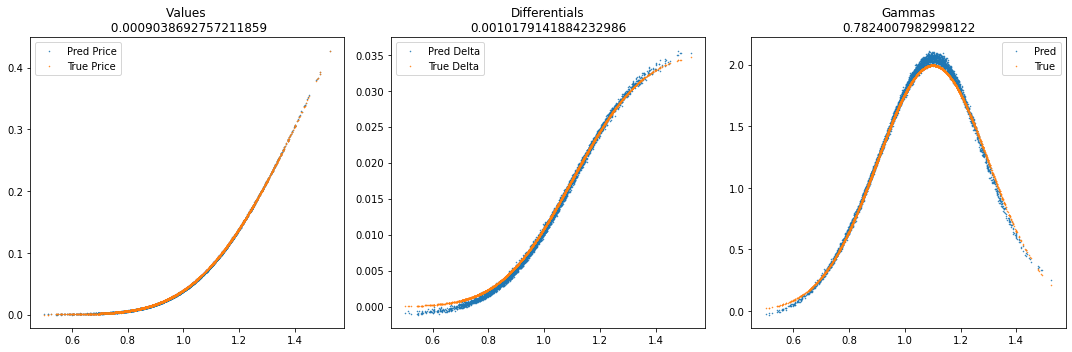

In [55]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "second_order_dml")

# Multiple run average

In [338]:
def multi_run_stats(gen_data: Callable, learning_method: Callable):
    results = []
    n_runs = 30
    for i in range(n_runs):  
        generator_train_ds, generator_test_ds, x_test = gen_data()
        key = jax.random.PRNGKey(42)
        model = learning_method(key)
    
        pred = predict(model, x_test)
        eval_iter = eval(pred, test_set)
        results.append(eval_iter)
        print(f"{i} finished")

    return results


In [354]:
def results_stats(results):
    np_results = np.array(results)
    results_mean = np_results.mean(axis=0)
    results_std = np_results.std(axis=0)
    return results_mean * 100, results_std * 100

## Standard ML

In [346]:
standard_ml_results = multi_run_stats(gen_data_standard_ml, bachelier_train_standard_ml)

Finished epoch   0  | Train Loss: 0.00555  | Test Loss: 0.03685
Finished epoch   1  | Train Loss: 0.00415  | Test Loss: 0.03562
Finished epoch   2  | Train Loss: 0.00300  | Test Loss: 0.02888
Finished epoch   3  | Train Loss: 0.00269  | Test Loss: 0.02741
Finished epoch   4  | Train Loss: 0.00234  | Test Loss: 0.02550
Finished epoch   5  | Train Loss: 0.00225  | Test Loss: 0.02351
Finished epoch   6  | Train Loss: 0.00214  | Test Loss: 0.02143
Finished epoch   7  | Train Loss: 0.00228  | Test Loss: 0.01896
Finished epoch   8  | Train Loss: 0.00187  | Test Loss: 0.01736
Finished epoch   9  | Train Loss: 0.00187  | Test Loss: 0.01592
Finished epoch  10  | Train Loss: 0.00190  | Test Loss: 0.01461
Finished epoch  11  | Train Loss: 0.00173  | Test Loss: 0.01315
Finished epoch  12  | Train Loss: 0.00160  | Test Loss: 0.01222
Finished epoch  13  | Train Loss: 0.00147  | Test Loss: 0.01122
Finished epoch  14  | Train Loss: 0.00160  | Test Loss: 0.00987
Finished epoch  15  | Train Loss: 0.0017

In [355]:
standard_ml_result_stats = results_stats(standard_ml_results)

In [356]:
standard_ml_result_stats

(array([ 0.31997551,  0.53173396, 97.62509659]),
 array([0.02202675, 0.00911322, 0.33448037]))

## Differential ML

In [374]:
dml_results =  multi_run_stats(gen_data_dml, bachelier_train_dml)

Finished epoch   0  | Train Loss: 0.00144  | Test Loss: 0.02124
Finished epoch   1  | Train Loss: 0.00107  | Test Loss: 0.00837
Finished epoch   2  | Train Loss: 0.00100  | Test Loss: 0.00422
Finished epoch   3  | Train Loss: 0.00104  | Test Loss: 0.00420
Finished epoch   4  | Train Loss: 0.00106  | Test Loss: 0.00205
Finished epoch   5  | Train Loss: 0.00102  | Test Loss: 0.00390
Finished epoch   6  | Train Loss: 0.00102  | Test Loss: 0.00284
Finished epoch   7  | Train Loss: 0.00110  | Test Loss: 0.00234
Finished epoch   8  | Train Loss: 0.00109  | Test Loss: 0.00190
Finished epoch   9  | Train Loss: 0.00106  | Test Loss: 0.00387
Finished epoch  10  | Train Loss: 0.00108  | Test Loss: 0.00761
Finished epoch  11  | Train Loss: 0.00106  | Test Loss: 0.00505
Finished epoch  12  | Train Loss: 0.00099  | Test Loss: 0.00381
Finished epoch  13  | Train Loss: 0.00096  | Test Loss: 0.00295
Finished epoch  14  | Train Loss: 0.00106  | Test Loss: 0.00356
Finished epoch  15  | Train Loss: 0.0010

In [375]:
dml_results_stats = results_stats(dml_results)
dml_results_stats

(array([ 0.12272007,  0.26067469, 87.39031006]),
 array([0.00879266, 0.02539028, 2.20089626]))

## Second-Order Differential ML

In [366]:
second_order_results =  multi_run_stats(gen_data_second_order_dml, bachelier_train_second_order)

Finished epoch   0  | Train Loss (RMSE): 0.046268  | Test Loss (RMSE): 0.074493
Finished epoch   1  | Train Loss (RMSE): 0.040436  | Test Loss (RMSE): 0.057559
Finished epoch   2  | Train Loss (RMSE): 0.038375  | Test Loss (RMSE): 0.047194
Finished epoch   3  | Train Loss (RMSE): 0.038019  | Test Loss (RMSE): 0.047425
Finished epoch   4  | Train Loss (RMSE): 0.037555  | Test Loss (RMSE): 0.048404
Finished epoch   5  | Train Loss (RMSE): 0.038891  | Test Loss (RMSE): 0.041558
Finished epoch   6  | Train Loss (RMSE): 0.037494  | Test Loss (RMSE): 0.051575
Finished epoch   7  | Train Loss (RMSE): 0.037443  | Test Loss (RMSE): 0.038309
Finished epoch   8  | Train Loss (RMSE): 0.044526  | Test Loss (RMSE): 0.053416
Finished epoch   9  | Train Loss (RMSE): 0.043387  | Test Loss (RMSE): 0.047505
Finished epoch  10  | Train Loss (RMSE): 0.044812  | Test Loss (RMSE): 0.048984
Finished epoch  11  | Train Loss (RMSE): 0.044288  | Test Loss (RMSE): 0.050113
Finished epoch  12  | Train Loss (RMSE):

In [367]:
second_order_result_stats = results_stats(second_order_results)
second_order_result_stats

(array([ 0.1044704 ,  0.15540309, 75.52026846]),
 array([0.01818872, 0.01497825, 0.59832679]))

## Second-Order Differential ML (Random Directions)

In [517]:
second_order_results =  multi_run_stats(gen_data_second_order_dml, bachelier_train_second_order)

Finished epoch   0  | Train Loss (RMSE): 0.047715  | Test Loss (RMSE): 0.023812
Finished epoch   1  | Train Loss (RMSE): 0.042958  | Test Loss (RMSE): 0.006334
Finished epoch   2  | Train Loss (RMSE): 0.040936  | Test Loss (RMSE): 0.004752
Finished epoch   3  | Train Loss (RMSE): 0.019519  | Test Loss (RMSE): 0.012757
Finished epoch   4  | Train Loss (RMSE): 0.040544  | Test Loss (RMSE): 0.003764
Finished epoch   5  | Train Loss (RMSE): 0.039218  | Test Loss (RMSE): 0.002825
Finished epoch   6  | Train Loss (RMSE): 0.040200  | Test Loss (RMSE): 0.006386
Finished epoch   7  | Train Loss (RMSE): 0.038667  | Test Loss (RMSE): 0.004658
Finished epoch   8  | Train Loss (RMSE): 0.038268  | Test Loss (RMSE): 0.001915
Finished epoch   9  | Train Loss (RMSE): 0.037811  | Test Loss (RMSE): 0.006700
Finished epoch  10  | Train Loss (RMSE): 0.040346  | Test Loss (RMSE): 0.002269
Finished epoch  11  | Train Loss (RMSE): 0.038236  | Test Loss (RMSE): 0.005376
Finished epoch  12  | Train Loss (RMSE):

In [518]:
second_order_rng_result_stats = results_stats(second_order_results)
second_order_rng_result_stats

(array([ 0.09867078,  0.23068706, 87.39177102]),
 array([0.003808  , 0.00973607, 1.3130049 ]))

# Higher-Dimensional Example

In [70]:
bachelier_params = BachelierParams(n_dim=50, anti=True)
training_set = trainingSet(2*N_TRAINING_SAMPLES, bachelier_params, seed=SEED)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=2*N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
inc0.shape is (array(16384), array(50))
chol0 is (array(50), array(50))
normals 0 is (array(16384), array(50))
cov (array(50), array(50))
diagv (array(50), array(50))
v.shape is (array(1),)
avols is (array(50), array(1))
vols is (array(50),)
basket asset weights are [0.01510942 0.01779015 0.01815808 0.00522257 0.00859953 0.02037792
 0.02407101 0.02862962 0.02700281 0.01871849 0.01494417 0.03194406
 0.01129532 0.02638648 0.02702967 0.01937238 0.01128282 0.00852788
 0.03196015 0.00672648 0.00661637 0.0254822  0.03143102 0.02712621
 0.02943937 0.02464247 0.03200091 0.02919737 0.02210688 0.00476969
 0.0120436  0.02579337 0.0315291  0.01925971 0.03095962 0.03080366
 0.02144629 0.00625647 0.00777488 0.02342361 0.02071266 0.03316174
 0.02348729 0.01378414 0.02012187 0.02879512 0.02612774 0.00687371
 0.00665521 0.00502871]
corr is [[ 1.          0.00783419  0.03749608 ... -0.18391745  0.12433128
   0.03189646]
 [ 0.00783419  1.          0.0246213  ... -0.13765595  0.01244705
  

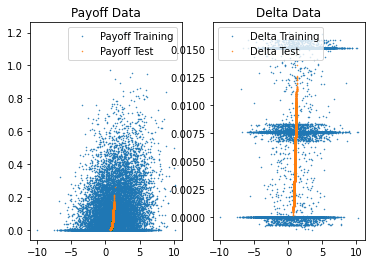

In [71]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

In [72]:
x_train, y_train, dydx_train = X, Y, Z

## Standard ML

In [73]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [74]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# lr_schedule = optax.constant_schedule(.005)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.01154  | Test Loss: 0.03524
Finished epoch   1  | Train Loss: 0.00622  | Test Loss: 0.02240
Finished epoch   2  | Train Loss: 0.00380  | Test Loss: 0.01789
Finished epoch   3  | Train Loss: 0.00321  | Test Loss: 0.01689
Finished epoch   4  | Train Loss: 0.00253  | Test Loss: 0.01518
Finished epoch   5  | Train Loss: 0.00231  | Test Loss: 0.01312
Finished epoch   6  | Train Loss: 0.00208  | Test Loss: 0.01166
Finished epoch   7  | Train Loss: 0.00167  | Test Loss: 0.01038
Finished epoch   8  | Train Loss: 0.00179  | Test Loss: 0.00914
Finished epoch   9  | Train Loss: 0.00219  | Test Loss: 0.00835
Finished epoch  10  | Train Loss: 0.00183  | Test Loss: 0.00794
Finished epoch  11  | Train Loss: 0.00163  | Test Loss: 0.00726
Finished epoch  12  | Train Loss: 0.00159  | Test Loss: 0.00681
Finished epoch  13  | Train Loss: 0.00158  | Test Loss: 0.00642
Finished epoch  14  | Train Loss: 0.00187  | Test Loss: 0.00628
Finished epoch  15  | Train Loss: 0.0017

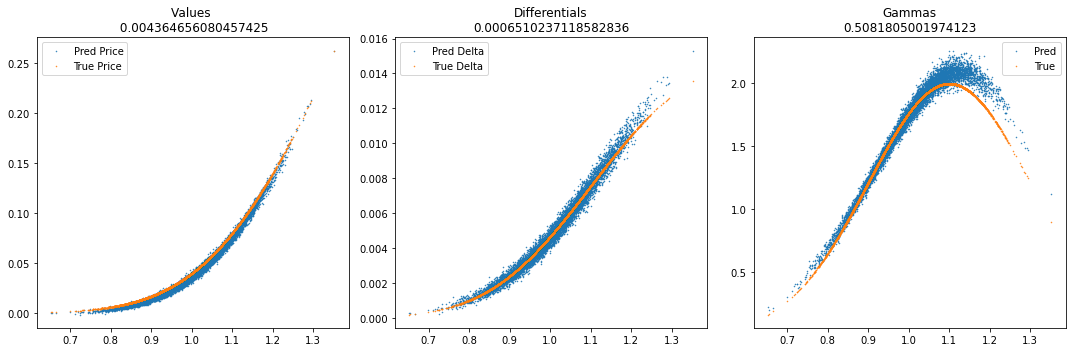

In [75]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "ml")

## Differential ML

In [76]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [77]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [78]:

num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00006  | Test Loss: 0.00428
Finished epoch   1  | Train Loss: 0.00004  | Test Loss: 0.00641
Finished epoch   2  | Train Loss: 0.00005  | Test Loss: 0.00507
Finished epoch   3  | Train Loss: 0.00004  | Test Loss: 0.00461
Finished epoch   4  | Train Loss: 0.00005  | Test Loss: 0.00356
Finished epoch   5  | Train Loss: 0.00004  | Test Loss: 0.00270
Finished epoch   6  | Train Loss: 0.00004  | Test Loss: 0.00363
Finished epoch   7  | Train Loss: 0.00005  | Test Loss: 0.00304
Finished epoch   8  | Train Loss: 0.00005  | Test Loss: 0.00215
Finished epoch   9  | Train Loss: 0.00005  | Test Loss: 0.00272
Finished epoch  10  | Train Loss: 0.00005  | Test Loss: 0.00320
Finished epoch  11  | Train Loss: 0.00005  | Test Loss: 0.00349
Finished epoch  12  | Train Loss: 0.00005  | Test Loss: 0.00211
Finished epoch  13  | Train Loss: 0.00005  | Test Loss: 0.00232
Finished epoch  14  | Train Loss: 0.00004  | Test Loss: 0.00174
Finished epoch  15  | Train Loss: 0.0000

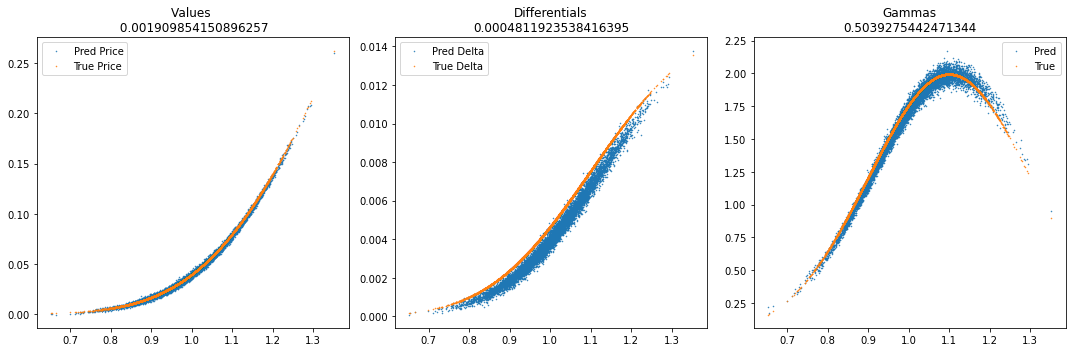

In [79]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "dml")

## Second-Order Differential ML

In [80]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [85]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = 25 # NUM_EPOCHS

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)

Finished epoch   0  | Train Loss (RMSE): 0.007365  | Test Loss (RMSE): 0.013981
Finished epoch   1  | Train Loss (RMSE): 0.006925  | Test Loss (RMSE): 0.006344
Finished epoch   2  | Train Loss (RMSE): 0.006957  | Test Loss (RMSE): 0.005203
Finished epoch   3  | Train Loss (RMSE): 0.007137  | Test Loss (RMSE): 0.003464
Finished epoch   4  | Train Loss (RMSE): 0.006274  | Test Loss (RMSE): 0.004845
Finished epoch   5  | Train Loss (RMSE): 0.006942  | Test Loss (RMSE): 0.003484
Finished epoch   6  | Train Loss (RMSE): 0.006760  | Test Loss (RMSE): 0.003523
Finished epoch   7  | Train Loss (RMSE): 0.007234  | Test Loss (RMSE): 0.003352
Finished epoch   8  | Train Loss (RMSE): 0.005252  | Test Loss (RMSE): 0.003157
Finished epoch   9  | Train Loss (RMSE): 0.007028  | Test Loss (RMSE): 0.003103
Finished epoch  10  | Train Loss (RMSE): 0.007105  | Test Loss (RMSE): 0.003118
Finished epoch  11  | Train Loss (RMSE): 0.006616  | Test Loss (RMSE): 0.003859
Finished epoch  12  | Train Loss (RMSE):

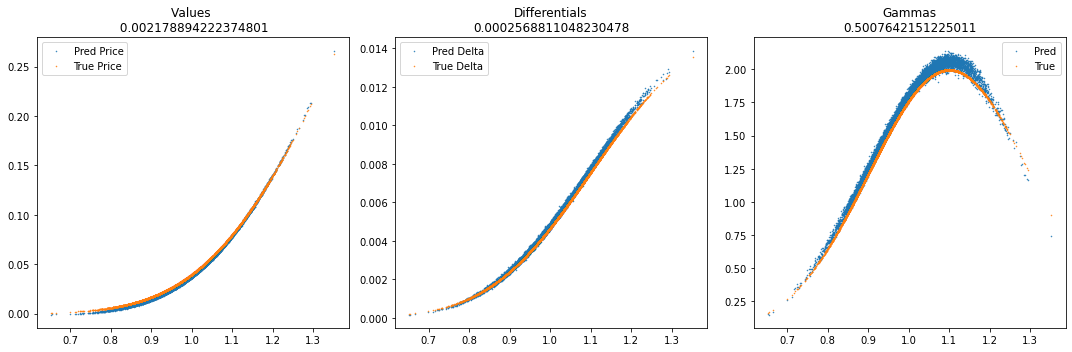

In [86]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "sodml")

# Higher-Dimensional Example | More Data

In [93]:
# free previously allocated device memory
backend = jax.lib.xla_bridge.get_backend()
for buf in backend.live_buffers(): buf.delete()

In [94]:
bachelier_params = BachelierParams(n_dim=50, anti=False)
training_set = trainingSet(2*N_TRAINING_SAMPLES, bachelier_params, seed=SEED)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=4*2*N_TEST_SAMPLES) # NOTE: only the 4* has been added
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
z_analytic (array(16384), array(50))
weights (array(1), array(50))
analytic (array(16384), array(1))
inc0.shape is (array(16384), array(50))
chol0 is (array(50), array(50))
normals 0 is (array(16384), array(50))
cov (array(50), array(50))
diagv (array(50), array(50))
v.shape is (array(1),)
avols is (array(50), array(1))
vols is (array(50),)
basket asset weights are [0.01510942 0.01779015 0.01815808 0.00522257 0.00859953 0.02037792
 0.02407101 0.02862962 0.02700281 0.01871849 0.01494417 0.03194406
 0.01129532 0.02638648 0.02702967 0.01937238 0.01128282 0.00852788
 0.03196015 0.00672648 0.00661637 0.0254822  0.03143102 0.02712621
 0.02943937 0.02464247 0.03200091 0.02919737 0.02210688 0.00476969
 0.0120436  0.02579337 0.0315291  0.01925971 0.03095962 0.03080366
 0.02144629 0.00625647 0.00777488 0.02342361 0.02071266 0.03316174
 0.02348729 0.01378414 0.02012187 0.02879512 0.02612774 0.00687371
 0.00665521 0.00502871]
corr is [[ 1.          0.00783419  0.03749608 ... -0.183

In [95]:
x_train, y_train, dydx_train = X, Y, Z

In [96]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [97]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# lr_schedule = optax.constant_schedule(.005)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

RuntimeError: Array has been deleted with shape=float64[].

2023-11-08 13:05:26.764834: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.00GiB (rounded to 8589934592)requested by op 
2023-11-08 13:05:26.765050: W external/tsl/tsl/framework/bfc_allocator.cc:497] *****__*******************************************************************************************__
2023-11-08 13:05:26.765089: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8589934592 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    8.00GiB
              constant allocation:         0B
        maybe_live_out allocation:    8.00GiB
     preallocated temp allocation:         0B
                 total allocation:   16.00GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 8.00GiB
		Entry Parameter Subshape: f64[32768,32768]

	Buffer 2:

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8589934592 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    8.00GiB
              constant allocation:         0B
        maybe_live_out allocation:    8.00GiB
     preallocated temp allocation:         0B
                 total allocation:   16.00GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 8.00GiB
		Entry Parameter Subshape: f64[32768,32768]
		==========================

	Buffer 2:
		Size: 8.00GiB
		Operator: op_name="jit(integer_pow)/jit(main)/mul" source_file="/w0/tmp/slurm_fc202177.40685958/ipykernel_84564/418623370.py" source_line=2
		XLA Label: fusion
		Shape: f64[32768,32768]
		==========================



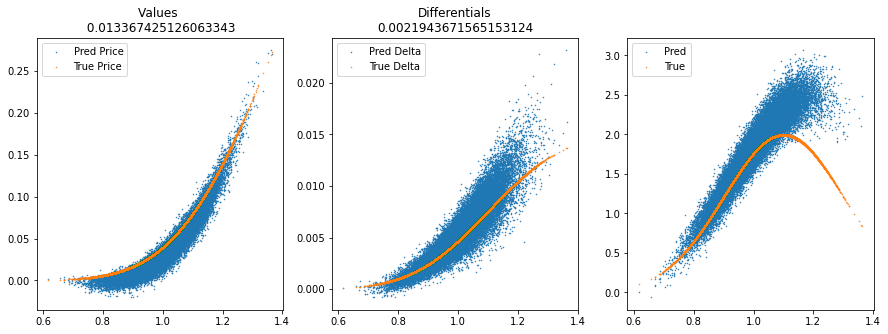

In [92]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "ml")

## Differential ML

In [460]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [461]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [462]:

num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00035  | Test Loss: 0.02929
Finished epoch   1  | Train Loss: 0.00032  | Test Loss: 0.02091
Finished epoch   2  | Train Loss: 0.00031  | Test Loss: 0.01797
Finished epoch   3  | Train Loss: 0.00028  | Test Loss: 0.01738
Finished epoch   4  | Train Loss: 0.00031  | Test Loss: 0.01559
Finished epoch   5  | Train Loss: 0.00029  | Test Loss: 0.01553
Finished epoch   6  | Train Loss: 0.00033  | Test Loss: 0.00860
Finished epoch   7  | Train Loss: 0.00030  | Test Loss: 0.00825
Finished epoch   8  | Train Loss: 0.00032  | Test Loss: 0.01142
Finished epoch   9  | Train Loss: 0.00032  | Test Loss: 0.00975
Finished epoch  10  | Train Loss: 0.00027  | Test Loss: 0.00916
Finished epoch  11  | Train Loss: 0.00028  | Test Loss: 0.00901
Finished epoch  12  | Train Loss: 0.00032  | Test Loss: 0.00811
Finished epoch  13  | Train Loss: 0.00028  | Test Loss: 0.01081
Finished epoch  14  | Train Loss: 0.00032  | Test Loss: 0.00924
Finished epoch  15  | Train Loss: 0.0003

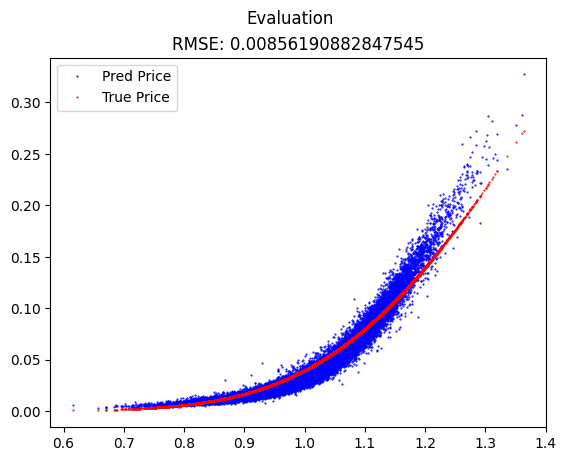

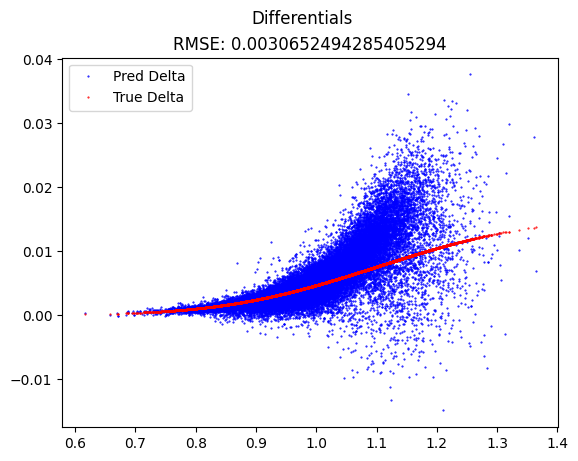

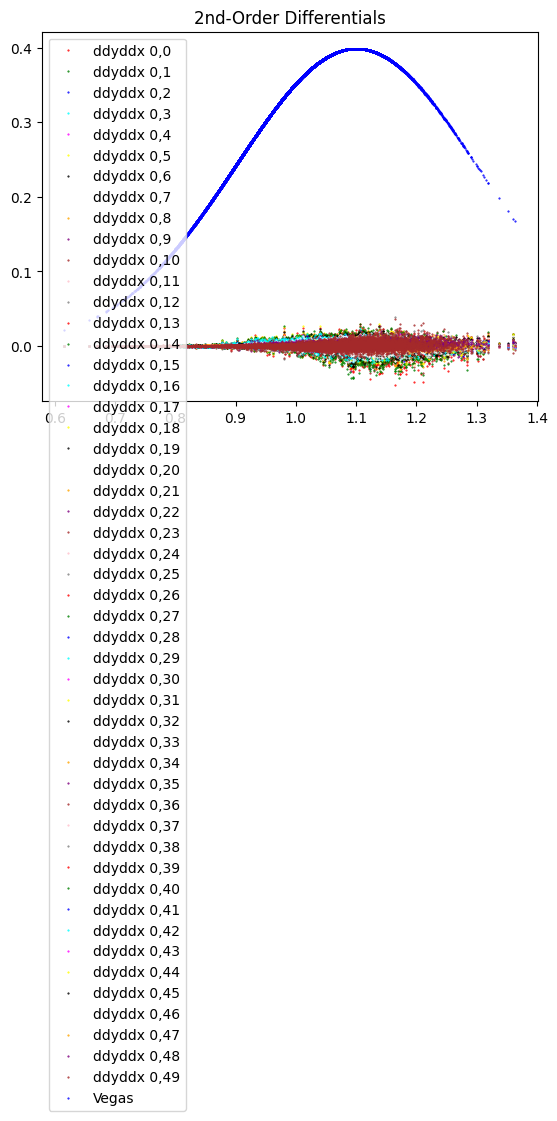

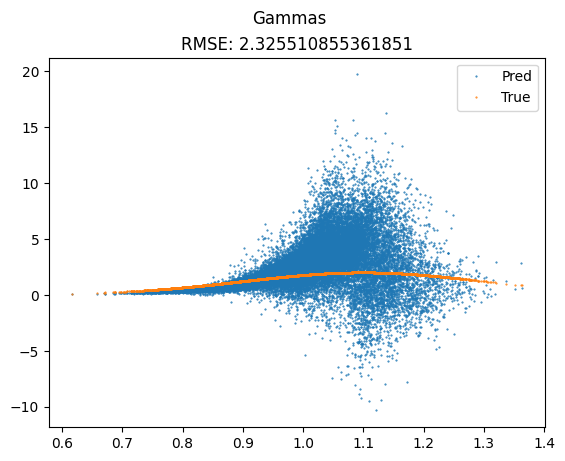

In [463]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Second-Order Differential ML

In [464]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [465]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = 25 # NUM_EPOCHS

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# lr_schedule = optax.constant_schedule(.005)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)

Finished epoch   0  | Train Loss (RMSE): 0.017413  | Test Loss (RMSE): 0.013897
Finished epoch   1  | Train Loss (RMSE): 0.018892  | Test Loss (RMSE): 0.011664
Finished epoch   2  | Train Loss (RMSE): 0.017851  | Test Loss (RMSE): 0.007550
Finished epoch   3  | Train Loss (RMSE): 0.017518  | Test Loss (RMSE): 0.009700
Finished epoch   4  | Train Loss (RMSE): 0.016389  | Test Loss (RMSE): 0.008969
Finished epoch   5  | Train Loss (RMSE): 0.017274  | Test Loss (RMSE): 0.008413
Finished epoch   6  | Train Loss (RMSE): 0.017327  | Test Loss (RMSE): 0.010559
Finished epoch   7  | Train Loss (RMSE): 0.018349  | Test Loss (RMSE): 0.009590
Finished epoch   8  | Train Loss (RMSE): 0.018153  | Test Loss (RMSE): 0.006777
Finished epoch   9  | Train Loss (RMSE): 0.017476  | Test Loss (RMSE): 0.007292
Finished epoch  10  | Train Loss (RMSE): 0.018090  | Test Loss (RMSE): 0.007003
Finished epoch  11  | Train Loss (RMSE): 0.016227  | Test Loss (RMSE): 0.008073
Finished epoch  12  | Train Loss (RMSE):

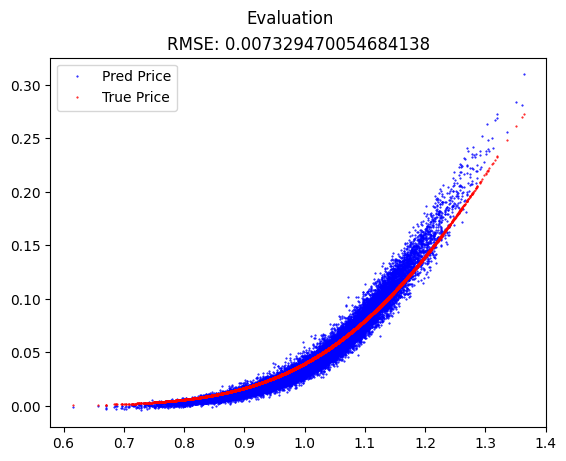

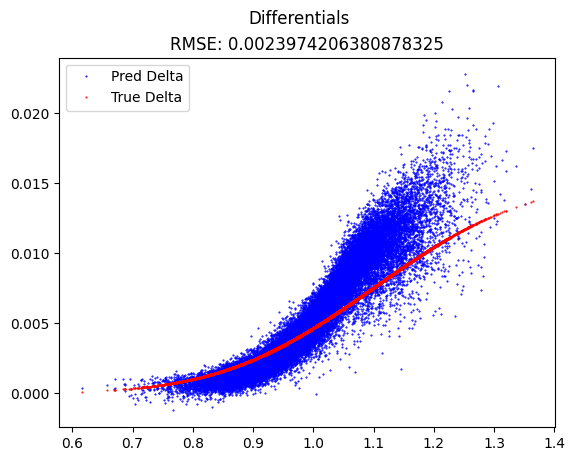

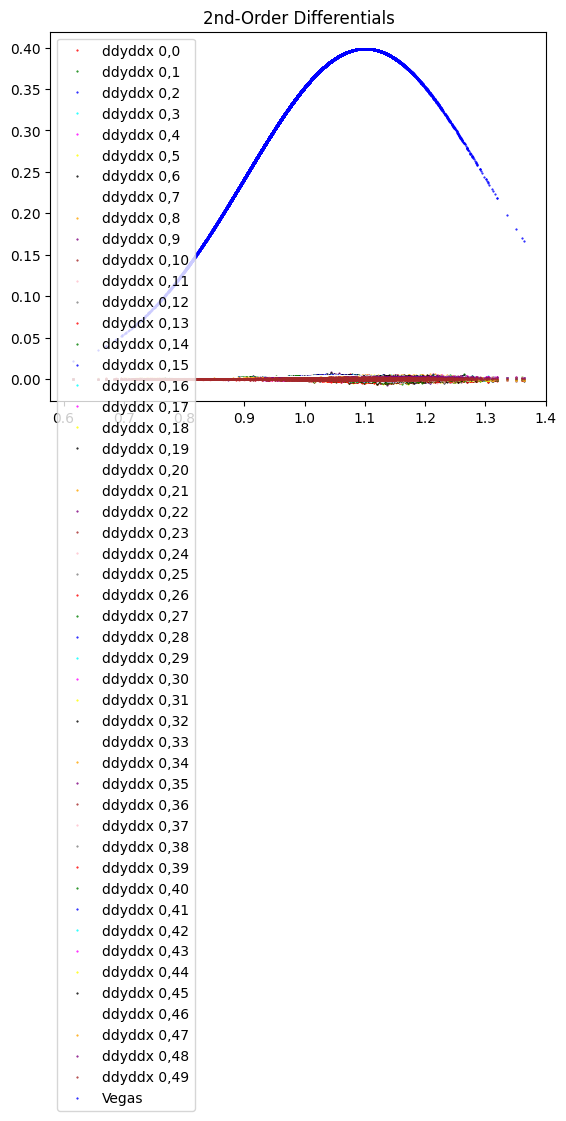

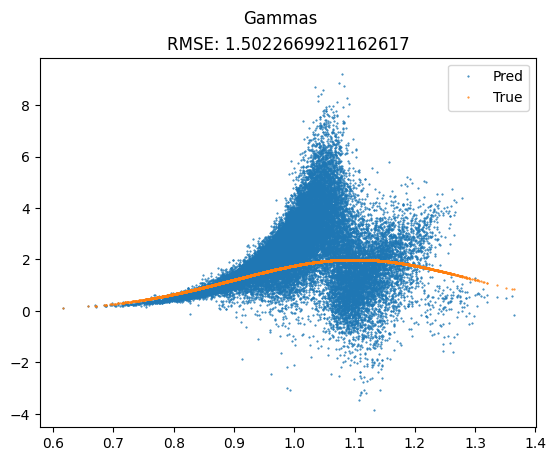

In [466]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

# Higher-Dimensional Example | Even More Data

In [467]:
bachelier_params = BachelierParams(n_dim=50, anti=False)
training_set = trainingSet(2*N_TRAINING_SAMPLES, bachelier_params, seed=SEED)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=8*2*N_TEST_SAMPLES) # NOTE: only the 4* has been added
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
Z_vjp.shape = (array(16384), array(50))
Z_vjp_full.shape = (array(16384), array(16384), array(50))
S1.shape (array(16384), array(50))
vols is= [1.61834243 0.23311001 2.02621835 0.86097384 0.5682461  1.84731477
 1.14461162 2.04225819 0.88782623 1.06209296 1.44785184 1.43395327
 0.8472135  0.54047667 1.95361304 1.11406856 1.4894639  0.61371415
 0.5398553  0.28663245 1.32788614 1.7500956  1.82629479 0.43480857
 1.47819178 0.58074326 1.75414926 1.88371637 1.33249193 1.22274022
 1.82001722 1.21349427 0.86935726 1.53753871 1.68838973 0.35806156
 1.17997044 0.72095207 1.97362881 0.57600784 0.25543817 0.25446687
 0.62897849 1.81625769 0.68090986 1.69320869 0.51796785 1.29738986
 1.43607208 0.78156973]
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Example values: 0.015109423935468167, 0.015109423935468167
W_fd_of_fd vs W_fd_of_vjp 0.0001908557486611484
MSE(Z_grad, Z_analytic) = 4.6509939630712036e-07
MSE(Z_vjp, Z_analytic) = 4.6509939630712036e-07
Close(Z_vjp, Z) ? False
Close(Z_gr

In [468]:
x_train, y_train, dydx_train = X, Y, Z

In [469]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [470]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# lr_schedule = optax.constant_schedule(.005)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.02967  | Test Loss: 0.04993
Finished epoch   1  | Train Loss: 0.02392  | Test Loss: 0.03981
Finished epoch   2  | Train Loss: 0.01907  | Test Loss: 0.03440
Finished epoch   3  | Train Loss: 0.01651  | Test Loss: 0.03263
Finished epoch   4  | Train Loss: 0.01561  | Test Loss: 0.03270
Finished epoch   5  | Train Loss: 0.01241  | Test Loss: 0.03287
Finished epoch   6  | Train Loss: 0.01471  | Test Loss: 0.03315
Finished epoch   7  | Train Loss: 0.01088  | Test Loss: 0.03294
Finished epoch   8  | Train Loss: 0.01205  | Test Loss: 0.03258
Finished epoch   9  | Train Loss: 0.01435  | Test Loss: 0.03228
Finished epoch  10  | Train Loss: 0.01305  | Test Loss: 0.03230
Finished epoch  11  | Train Loss: 0.01301  | Test Loss: 0.03107
Finished epoch  12  | Train Loss: 0.01233  | Test Loss: 0.03107
Finished epoch  13  | Train Loss: 0.01455  | Test Loss: 0.03055
Finished epoch  14  | Train Loss: 0.01153  | Test Loss: 0.03014
Finished epoch  15  | Train Loss: 0.0125

In [471]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

2023-07-24 17:51:49.880597: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 516.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 541065216 bytes.

## Differential ML

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [ ]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [ ]:

num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

In [ ]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Second-Order Differential ML

In [ ]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [ ]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = 25 # NUM_EPOCHS

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# lr_schedule = optax.constant_schedule(.005)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)

In [ ]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Experiment

In [703]:
def f(x):
  return x**2

xs = jnp.array([[3., 2., 1.]])
dys = jnp.array([[3., 2., 1.], 
                 [3., 2., 1.], 
                 [3., 2., 1.]])

pcs = jnp.array([[3., 2., 1.], 
                 [1., 1., 1.], 
                 [1., 2., 3.]])

print(xs.shape)
print(dys.shape)

print(xs @ dys)

print(pcs @ dys)
print(dys @ pcs)
# print(jnp.vdot(xs, dys))

hessian = jnp.tile(dys, (256, 1, 1))
print(hessian.shape)
print(pcs.shape)

# broadcasts the pcs accordingly
hvp = pcs @ hessian
print(hvp.shape)


(1, 3)
(3, 3)
[[18. 12.  6.]]
[[18. 12.  6.]
 [ 9.  6.  3.]
 [18. 12.  6.]]
[[12. 10.  8.]
 [12. 10.  8.]
 [12. 10.  8.]]
(256, 3, 3)
(3, 3)
(256, 3, 3)


In [704]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

dys = vmap(grad(f))(xs)
print(dys)
print(dys.shape)
# only now we know the vectors
# vs = 

# jnp.vdot(dys, jnp.ones_like(dys))

vmap(jax.hessian(f))(xs)
jax.hessian(f)(xs)

[6. 4. 2.]
(3,)


Array([[[2., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 2.]]], dtype=float32)

In [54]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

y, vjp_fn = jax.vjp(f, xs)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy_vjp, vjpvjp_fn = jax.vjp(vjp_fn, jnp.ones_like(y))
print(dy_vjp)

# ddy = vjpvjp_fn(jnp.ones_like(dy_vjp))
# ddy = vjpvjp_fn((jnp.ones_like(dy_vjp[0]),))
# print(ddy)

# hvp(f, xs, xs)

hess = jax.hessian(f)
print(vmap(hess)(xs))


[9. 4. 1.]
(Array([6., 4., 2.], dtype=float32),)
(Array([6., 4., 2.], dtype=float32),)
[2. 2. 2.]


In [55]:
def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = jax.vjp(f, x)
print(y)

cotanget = (jnp.ones_like(y[0]), )
dy = vjp_fn(cotanget)
print(len(dy))
cotanget = (jnp.ones_like(dy[0]), )

dy_, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
if 0:
    print(dy)
    print(dy_)
    dy_ = dy_[0]
    # print(vmap(vjpvjp_fn)((jnp.ones_like(dy_), )))
    print(vjpvjp_fn((jnp.ones_like(dy_), )))

    print(jax.jacobian(f)(x))
    print(jax.hessian(f)(x))


[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]


TypeError: Tree structure of cotangent input PyTreeDef((*,)), does not match structure of primal output PyTreeDef(*).

In [ ]:
# with eqx

def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = eqx.filter_vjp(f, x)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
print(dy)

[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)


In [ ]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)

jac = jax.jacobian(model)(x)
hess = jax.hessian(model)(x)
# y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
# print("y", y)

y, J, vjp_fn = value_and_jacrev(model, x)

# print(y.size)

def hvp(f, v):
    dy, vjpvjp_fn = eqx.filter_vjp(f, v)
    dy = dy[0]
    basis = jnp.eye(dy.size, dtype=dy.dtype)
    H = vmap(vjpvjp_fn)((basis,))
    return dy, H

# dy, H = hvp(vjp_fn, jnp.ones_like(y))
# print("dy", dy)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
dy0 = dy[0]
basis = jnp.eye(dy0.size, dtype=dy0.dtype) # same as jnp.eye(x.size, dtype=x.dtype)

def vjpvjp_el(v):
    return vjpvjp_fn((v,)) 

# ddy = vjpvjp_fn((basis[0],))
ddy = vjpvjp_fn((jnp.ones_like(dy0),))
print("dy", dy)
print("ddy", ddy)

H = vmap(vjpvjp_el)(basis)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):

    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

hvp_res = hvp(MakeScalar(model), (x,), (basis[0],))
print("hvp: ", hvp_res)

hmp_fn = hmp(MakeScalar(model), x)
hvp_res = hmp_fn(basis)
print("hmp: ", hvp_res)

print(y_)
print(y)

print(jac)
print(J)

print(hess)
print(H)

dy (Array([-0.00836775, -0.00073751, -0.00439059, -0.00280592, -0.00235696,
       -0.0056589 , -0.00504256], dtype=float32),)
ddy (Array([-0.02936021], dtype=float32),)
hvp:  [-6.1080320e-04 -2.3331182e-04 -9.3602127e-04 -3.3858477e-04
 -8.6907647e-04 -9.5272699e-06 -1.3695123e-04]
hmp:  [[-6.1080308e-04 -2.3331185e-04 -9.3602127e-04 -3.3858477e-04
  -8.6907664e-04 -9.5272335e-06 -1.3695104e-04]
 [-2.3331189e-04  1.7222749e-04 -3.7502850e-04 -1.7532007e-05
  -5.3374610e-05 -1.4621431e-05 -7.0111157e-04]
 [-9.3602150e-04 -3.7502850e-04 -8.4217149e-04  7.5299118e-04
   5.8836385e-04  4.5638336e-04 -1.5317803e-03]
 [-3.3858471e-04 -1.7531909e-05  7.5299095e-04  7.7574287e-04
   3.8701249e-04 -1.7244610e-04 -6.1574130e-04]
 [-8.6907647e-04 -5.3374501e-05  5.8836397e-04  3.8701255e-04
  -1.8838544e-04 -4.7550054e-04 -5.6692900e-04]
 [-9.5272526e-06 -1.4621274e-05  4.5638336e-04 -1.7244593e-04
  -4.7550065e-04 -4.1496183e-04  1.8320826e-04]
 [-1.3695117e-04 -7.0111186e-04 -1.5317801e-03 -6.

In [ ]:
# now same as above but with a batch of vector data
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 7))
y_ = vmap(MakeScalar(model))(x)

print(x)
print(y_)

jac = vmap(jax.jacobian(model))(x)
hess = eqx.filter_jit(vmap(jax.hessian(model)))(x)

jac_ = vmap(jax.grad(MakeScalar(model)))(x)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals,), (tangents,))

    # return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))
    return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))


# def batch_hmp_pca(f):

#     def hvp_(primals, tangents):
#         return hvp(f, (primals,), (tangents,))

#     fn = eqx.filter_vmap(hvp_, in_axes=(0, None))
#     jax.lax.cond(pred, lambda x: x, lambda x: jnp.zeros_like(x), x)

#     return eqx.filter_jit(eqx.filter_vmap(, in_axes=(None, 1)))


basis = jnp.eye(x.shape[-1], dtype=x.dtype)
print(basis.shape)
hvp_res = hvp(MakeScalar(model), (x[0],), (basis[0],))


hmp_fn = hmp(MakeScalar(model), x[0])
hvp_res = hmp_fn(basis)

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_res = batch_hmp_fn(x, basis)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_res", batch_hmp_res)

hess_vs_hmp = jnp.allclose(hess[:, 0, :, :], batch_hmp_res)
print("hmp close to hess: ", hess_vs_hmp)


@eqx.filter_jit
def dynamic_slices_do_not_work():
    k = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
    print('k', k)

    batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :k])
    batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
    print("bath_hmp_selected", batch_hmp_selected.shape)
    print("bath_hmp_selected", batch_hmp_selected)

# the following does not work in jax
# dynamic_slices_do_not_work()

# have to avoid jit to make it work
batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :2])
batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
print("bath_hmp_selected", batch_hmp_selected.shape)
print("bath_hmp_selected", batch_hmp_selected)

# the following does work in jax
# we first set the tangents we do not want to compute to zero
# such that we internally skip those computations. Whether this is
# faster than computing everything and then selecting the relevant
# parts is unclear.
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))

# mask the basis to only compute the first 5 tangents
# basis_mask = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
# basis_mask = jnp.concatenate([jnp.ones(basis_mask), jnp.zeros(basis.size - basis_mask)])
# basis_mask = jnp.reshape(basis_mask, basis.shape)

# in numpy zero out the next n columns of basis
basis_masked = basis.at[:, 2:].set(0.)
batch_hmp_res = batch_hmp_fn_select(x, basis_masked)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_pca_res", batch_hmp_res)

print("jac from grad shape", jac_.shape)
print("jac from grad: ", jac_)
print("jacobian.shape", jac.shape)
print("jacobian", jac)
print("hessian.shape", hess.shape)
print("hessian", hess)

[[-1.0110744   0.8579503  -1.408211    0.30537882 -0.5529018  -0.20745467
  -0.91298896]
 [ 0.8951212  -1.7360477   0.47285226 -1.2633834   0.03138541  1.3681892
  -0.83616734]
 [-0.6514678   1.1204553  -2.0303192   0.5996085  -0.8729886   0.93188107
  -0.01794553]]
[0.03812329 0.00545319 0.02495258]
(7, 7)
batch_hmp_res [[[-3.3906644e-04 -7.7072233e-05 -7.4307172e-04 -7.3547720e-04
   -1.3029812e-03 -1.6769826e-04  7.4271910e-04]
  [-7.7072327e-05  7.7760153e-05 -2.1127101e-04  1.9880421e-05
   -2.7794237e-04 -2.2684189e-05 -3.4409881e-04]
  [-7.4307207e-04 -2.1127108e-04 -3.3174560e-04  5.8598543e-04
    2.5427618e-04  2.0159592e-04 -1.1795548e-03]
  [-7.3547708e-04  1.9880550e-05  5.8598537e-04  8.7144633e-04
    5.7646551e-04 -2.2871024e-04 -1.4743009e-03]
  [-1.3029811e-03 -2.7794242e-04  2.5427606e-04  5.7646557e-04
    1.0763346e-04 -3.4260331e-04 -1.2564788e-03]
  [-1.6769831e-04 -2.2684231e-05  2.0159601e-04 -2.2871017e-04
   -3.4260339e-04 -4.7583476e-04 -2.2669775e-04]
  [ 7

In [ ]:
# (small) benchmark 
# we observe that doing a select is slower than computing everything

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (8 * 1024, 100))
y = jax.random.normal(subkey, (8 * 1024, 1))
basis = jnp.eye(x.shape[-1], dtype=x.dtype)

key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x.shape[1], out_size=y.shape[1])

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))
%timeit batch_hmp_fn_select(x, basis) 
%timeit batch_hmp_fn(x, basis) 

basis_masked = basis.at[:, 2:].set(0.)

%timeit batch_hmp_fn_select(x, basis_masked) 
%timeit batch_hmp_fn(x, basis_masked) 



408 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
296 µs ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.9 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:

res_select = batch_hmp_fn_select(x, basis) 
res_normal = batch_hmp_fn(x, basis) 

print(res_select.shape)
# print(res_normal)
# print(jnp.sum(res_select - res_normal))

NameError: name 'batch_hmp_fn_select' is not defined

In [57]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)
# print(y_)

y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
print("y", y)

cotangent = jnp.ones_like(y)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, cotangent)
print("dy", dy)
print(vjp_fn(cotangent))

# ddy = vjpvjp_fn((jnp.ones_like(dy[0]),))
ddy = vjpvjp_fn(dy)
print("ddy", ddy)
print("x", x)

print(jax.hessian(model)(x))
print(jax.hessian(MakeScalar(model))(x))

# print(jax.vmap(jax.grad)(jax.grad(MakeScalar(model)))(x))

# eqx.filter_vmap(eqx.filter_grad)(eqx.filter_grad(MakeScalar(model)))(x)

if 0:
    y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
    print(y)
    print(y.shape)
    # dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
    # dy = vjp_fn((jnp.array([1.0]),))

    cotangent = jnp.ones(shape=())
    vjp_fn(cotangent)

y -0.013149001
dy (Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
(Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
ddy (Array(0.00023184, dtype=float32),)
x [-1.4986218  -0.05708544  0.09740688 -0.0673765  -0.90798175  0.17307237
  0.39909264]
[[[ 3.7015339e-03 -9.5647189e-04  3.4639451e-03  1.5701923e-04
   -1.6476470e-03  2.0245179e-03  1.9244381e-03]
  [-9.5647160e-04  2.5739521e-03 -3.9923601e-03 -1.6734296e-03
    3.5150332e-04 -1.7534450e-03 -2.5777954e-03]
  [ 3.4639449e-03 -3.9923610e-03  2.5150692e-03 -2.5630192e-04
   -3.4998145e-03  5.0159247e-04  1.6032613e-03]
  [ 1.5701915e-04 -1.6734299e-03 -2.5630163e-04 -1.4354529e-04
   -1.1739540e-03 -4.9362372e-04  2.0765999e-04]
  [-1.6476471e-03  3.5150276e-04 -3.4998143e-03 -1.1739542e-03
    1.0754332e-03 -1.7362719e-03 -1.9456412e-03]
  [ 2.0245172e-03 -1.7534447e-03  5.0159270e-

In [58]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7, 7))
# print(x.shape)
y_ = vmap(MakeScalar(model))(x)
# print(y_)

y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
print(y)
print(y.shape)
# dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
# dy = vjp_fn((jnp.array([1.0]),))

cotangent = jnp.ones(shape=())
vjp_fn(cotangent)

[-0.00530234  0.0136837   0.01398236 -0.00030544 -0.00558965 -0.03030739
 -0.00791175]
(7,)


TypeError: dot_general requires lhs dimension numbers to be nonnegative and less than the number of axes of the lhs value, got lhs_batch of () and lhs_contracting of (0, 1) for lhs of rank 1

In [ ]:
# experiment with using finite differences over vjp

def f(x):
  return 2 * x**3

xs = jnp.array([1.0, 2.0])
y, vjp_fn = jax.vjp(f, xs)
print(y)

cotangent = jnp.ones_like(y)
print(cotangent)
dy, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
print(dy)

# using ad
ddy = vjpvjp_fn((jnp.ones_like(y), ))
print(ddy)

# now using fd, NOTE: I don't actually need vjpvjp here
h = 1e-3

fd_xph = f(xs + jnp.array([h, h]))
fd_xmh = f(xs - jnp.array([h, h]))
fd = (fd_xph - fd_xmh) / (2 * h)
print("FD of f(x)")
print(fd)


fdd_xph, = vjp_fn(cotangent + jnp.array([h, h]))
fdd_xmh, = vjp_fn(cotangent - jnp.array([h, h]))

print(fdd_xph)
print(fdd_xmh)
fdd = (fdd_xph - fdd_xmh) / (2 * h)

print("FD over vjp of f(x)")
print(fdd)

grad_f = grad(f)

fdd_xph = vmap(grad_f)(xs + h)
fdd_xmh = vmap(grad_f)(xs - h)
fdd = (fdd_xph - fdd_xmh) / (2 * h)
print("FD over grad of f(x)")
print(fdd)

jax.hessian(f)(xs)

[ 2. 16.]
[1. 1.]
(Array([ 6., 24.], dtype=float32),)
(Array([ 6., 24.], dtype=float32),)
FD of f(x)
[ 6.0000415 23.99969  ]
[ 6.0060005 24.024002 ]
[ 5.994 23.976]
FD over vjp of f(x)
[ 6.00028 24.00112]
FD over grad of f(x)
[12.000083 23.999212]


Array([[[12.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0., 24.]]], dtype=float32)

In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

# xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = partial_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

[3. 2. 1.]
[9. 4. 1.]
()
9.0
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff0964c8040>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([6., 4., 2.], dtype=float32),)))
(Array([6., 4., 2.], dtype=float32),)


In [ ]:

def inner_fn(x):
    return x ** 3

def outer_fn(x):
    # def inner(x, y):
        # return inner_fn(x, y)
    
    _, vjp_inner = jax.vjp(inner_fn, x)
    cotangent = jnp.ones_like(x)
    grad_inner_x, = vjp_inner(x)
    return grad_inner_x

# Example usage
# x = jnp.array([2.0, 1.0])
x = jnp.array(1.0)
y = jnp.array(3.0)

grad_inner_x, vjp_outer = jax.vjp(outer_fn, x)
grad_outer_x = vjp_outer(1.0)

print(f"Gradient of inner_fn with respect to x: {grad_inner_x}")
print(f"Gradient of outer_fn with respect to x: {grad_outer_x}")
# print(f"Gradient of outer_fn with respect to y: {grad_outer_y}")

Gradient of inner_fn with respect to x: 3.0
Gradient of outer_fn with respect to x: (Array(9., dtype=float32, weak_type=True),)


In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = eqx.filter_vmap(partial_vjp)(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)


# this is an internal problem of the generated vjp_fn since 
# it probably gets confused with the vmap
# print(vjp_fn(jnp.ones_like(y[0])))

# but the below also doesn't work
# print(vjp_fn(jnp.ones_like(y)))

# print(vmap(vjp_fn)(jnp.ones(shape=(3,3))))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff210469fc0>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([[ 6.,  4.,  2.],
       [12., 10.,  8.],
       [18., 16., 14.]], dtype=float32),)))


In [ ]:
def f(x):
    return x**2

# maybe first vmap the vjp?
# partial_vjp = partial(jax.vjp, f)
vmap_vjp = vmap(lambda x: jax.vjp(f, x))

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = vmap_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])


#print(vjp_fn(jnp.ones_like(y)))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
